In [ ]:
from google.colab import drive
from google.colab import files

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
import json
from pathlib import Path
import numpy as np
from PIL import Image
import skimage
from pycocotools import mask as mask_util
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as ttf
import math
import os
import os.path as osp
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import roc_auc_score
import shutil

In [ ]:
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
num_workers = 4 if cuda else 0

In [ ]:
class VolumeSamples(torch.utils.data.Dataset):
  def __init__(self, data_path, partition= "train", context= 1, resize = 256):
    self.raw_paths = []
    self.mask_paths = []
    self.final_ids = []
    self.context = context
    self.resize = resize
    self.transforms = ttf.Compose([ttf.Resize((self.resize, self.resize)), ttf.ToTensor()])
    self.data_path = data_path + "/" #+ partition

    self.base_dirs = os.listdir(self.data_path)
    for sub_dir in self.base_dirs:
      raw_dir = self.data_path + "/" + sub_dir + "/Image/"
      mask_dir = self.data_path + "/"+ sub_dir + "/Mask/"
      ids = []
      for files in os.listdir(mask_dir):
        file_number = files[5:len(files)-4]
        if not file_number.isnumeric():
          continue
        file_id = int(file_number)
        overlaid_file = mask_dir + "maskOverlayedImg_" + str(file_id) + ".jpg"
        if not os.path.exists(overlaid_file):
          continue
        ids.append(file_id)
      for id in ids:
        temp = True
        for con in range(context):
          change = con + 1
          if not((id - change) in ids and (id + change) in ids):
            temp = False
        if temp:
          self.final_ids.append(id)
          raw_path = raw_dir + "img" + str(id).zfill(4) + ".jpg"
          mask_path = mask_dir + "mask_" + str(id) + ".jpg"
          self.raw_paths.append(raw_path)
          self.mask_paths.append(mask_path)

    assert(len(self.raw_paths) == len(self.mask_paths))

  def __len__(self):
    return len(self.mask_paths)

  def __getitem__(self, ind):

    mask_path = self.mask_paths[ind]
    raw_path = self.raw_paths[ind]
    center_mask = self.transforms(Image.open(self.mask_paths[ind]).convert('L'))
    center_raw = self.transforms(Image.open(self.raw_paths[ind]).convert('L'))

    full_mask = []
    full_raw = []

    full_mask.append(center_mask)
    full_raw.append(center_raw)

    file_id = self.final_ids[ind]
    for con in range(self.context):
      before_id = file_id - con - 1

      before_raw_path = raw_path[0:raw_path.find("img")+3] + str(before_id).zfill(4) + ".jpg"
      before_mask_path = mask_path[0:mask_path.find("mask_")+5] + str(before_id) + ".jpg"

      full_raw.insert(0, self.transforms(Image.open(before_raw_path).convert('L')))
      full_mask.insert(0, self.transforms(Image.open(before_mask_path).convert('L')))

      after_id = file_id + con + 1

      after_raw_path = raw_path[0:raw_path.find("img")+3] + str(after_id).zfill(4) + ".jpg"
      after_mask_path = mask_path[0:mask_path.find("mask_")+5] + str(after_id) + ".jpg"

      full_raw.append(self.transforms(Image.open(before_raw_path).convert('L')))
      full_mask.append(self.transforms(Image.open(before_mask_path).convert('L')))

    return center_mask, center_raw, full_mask, full_raw

In [ ]:
g_root = "/content/gdrive/MyDrive/11785/Data"
# root = "/content/Data/train"
root = "/content/Data/"
shutil.copytree(g_root, root)

'/content/Data/'

In [ ]:
batch_size = 4

root = "/content/Data"

data = VolumeSamples(root, 'train', context = 0, resize = 256)

loader = DataLoader(data, batch_size=batch_size, shuffle=True)

print("Batch size: ", batch_size)
print("Train dataset samples = {}, batches = {}".format(data.__len__(), len(loader)))

#val_data = VolumeSamples(root, 'val', context = 0, resize = 256)

#val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

#print("Batch size: ", batch_size)
#print("Val dataset samples = {}, batches = {}".format(val_data.__len__(), len(val_loader)))


Batch size:  4
Train dataset samples = 10812, batches = 2703


In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler
indices = list(range(len(data)))
# can shuffle data
#np.random.shuffle(indices)
#np.random.seed(random_seed)
split0 = int(0.6*len(data))
split = int(0.8*len(data))
train_idx, valid_idx, test_idx = indices[:split], indices[split0:split],indices[split:]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

In [ ]:
train_loader = DataLoader(
        data, batch_size=batch_size, sampler=train_sampler,
        num_workers=num_workers, pin_memory=True,
    )
valid_loader = DataLoader(
        data, batch_size=batch_size, sampler=valid_sampler,
        num_workers=num_workers, pin_memory=True,
    )
test_loader = DataLoader(
        data, batch_size=batch_size, sampler=test_sampler,
        num_workers=num_workers, pin_memory=True,
    )
print("Train dataset samples = {}, batches = {}".format(len(train_idx), len(train_loader)))
print("Valid dataset samples = {}, batches = {}".format(len(valid_idx), len(valid_loader)))
print("Test dataset samples = {}, batches = {}".format(len(test_idx), len(test_loader)))

Train dataset samples = 8649, batches = 2163
Valid dataset samples = 2162, batches = 541
Test dataset samples = 2163, batches = 541


torch.Size([4, 1, 256, 256]) torch.Size([4, 1, 256, 256]) 1 1


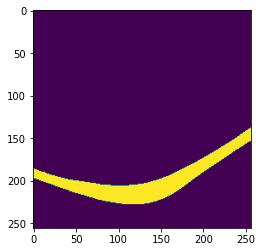

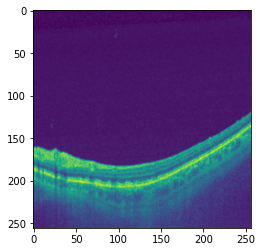

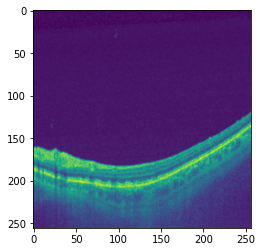

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
for data in train_loader:
    center_mask, center_raw, full_mask, full_raw = data
    print(center_mask.shape, center_raw.shape, len(full_mask), len(full_raw))
    plt.imshow(center_mask[0,:,:,:].reshape(256,256))
    fig = plt.figure()
    plt.imshow(center_raw[0,:,:,:].reshape(256,256))
    for i in range(len(full_raw)):
      fig = plt.figure()
      plt.imshow(full_raw[i][0,:,:,:].reshape(256,256))
    break

In [ ]:
class DeformConv2d(nn.Module):
    def __init__(self, inc, outc, kernel_size=3, padding=1, stride=1, bias=None, modulation=False):
        """
        Args:
            modulation (bool, optional): If True, Modulated Defomable Convolution (Deformable ConvNets v2).
        """
        super(DeformConv2d, self).__init__()
        self.kernel_size = kernel_size
        self.padding = padding
        self.stride = stride
        self.zero_padding = nn.ZeroPad2d(padding)
        self.conv = nn.Conv2d(inc, outc, kernel_size=kernel_size, stride=kernel_size, bias=bias)

        self.p_conv = nn.Conv2d(inc, 2*kernel_size*kernel_size, kernel_size=3, padding=1, stride=stride)
        torch.nn.init.xavier_normal_(self.p_conv.weight, gain=nn.init.calculate_gain('relu'))
        #self.p_conv.register_backward_hook(self._set_lr)

        self.modulation = modulation
        if modulation:
            self.m_conv = nn.Conv2d(inc, kernel_size*kernel_size, kernel_size=3, padding=1, stride=stride)
            nn.init.constant_(self.m_conv.weight, 0.5)
            self.m_conv.register_backward_hook(self._set_lr)

    @staticmethod
    def _set_lr(module, grad_input, grad_output):
        grad_input = (grad_input[i] * 0.1 for i in range(len(grad_input)))
        grad_output = (grad_output[i] * 0.1 for i in range(len(grad_output)))

    def forward(self, x):
        offset = self.p_conv(x)
        if self.modulation:
            m = torch.sigmoid(self.m_conv(x))

        dtype = offset.data.type()
        ks = self.kernel_size
        N = offset.size(1) // 2

        if self.padding:
            x = self.zero_padding(x)

        # (b, 2N, h, w)
        p = self._get_p(offset, dtype)

        # (b, h, w, 2N)
        p = p.contiguous().permute(0, 2, 3, 1)
        q_lt = p.detach().floor()
        q_rb = q_lt + 1

        q_lt = torch.cat([torch.clamp(q_lt[..., :N], 0, x.size(2)-1), torch.clamp(q_lt[..., N:], 0, x.size(3)-1)], dim=-1).long()
        q_rb = torch.cat([torch.clamp(q_rb[..., :N], 0, x.size(2)-1), torch.clamp(q_rb[..., N:], 0, x.size(3)-1)], dim=-1).long()
        q_lb = torch.cat([q_lt[..., :N], q_rb[..., N:]], dim=-1)
        q_rt = torch.cat([q_rb[..., :N], q_lt[..., N:]], dim=-1)

        # clip p
        p = torch.cat([torch.clamp(p[..., :N], 0, x.size(2)-1), torch.clamp(p[..., N:], 0, x.size(3)-1)], dim=-1)

        # bilinear kernel (b, h, w, N)
        g_lt = (1 + (q_lt[..., :N].type_as(p) - p[..., :N])) * (1 + (q_lt[..., N:].type_as(p) - p[..., N:]))
        g_rb = (1 - (q_rb[..., :N].type_as(p) - p[..., :N])) * (1 - (q_rb[..., N:].type_as(p) - p[..., N:]))
        g_lb = (1 + (q_lb[..., :N].type_as(p) - p[..., :N])) * (1 - (q_lb[..., N:].type_as(p) - p[..., N:]))
        g_rt = (1 - (q_rt[..., :N].type_as(p) - p[..., :N])) * (1 + (q_rt[..., N:].type_as(p) - p[..., N:]))

        # (b, c, h, w, N)
        x_q_lt = self._get_x_q(x, q_lt, N)
        x_q_rb = self._get_x_q(x, q_rb, N)
        x_q_lb = self._get_x_q(x, q_lb, N)
        x_q_rt = self._get_x_q(x, q_rt, N)

        # (b, c, h, w, N)
        x_offset = g_lt.unsqueeze(dim=1) * x_q_lt + \
                   g_rb.unsqueeze(dim=1) * x_q_rb + \
                   g_lb.unsqueeze(dim=1) * x_q_lb + \
                   g_rt.unsqueeze(dim=1) * x_q_rt

        # modulation
        if self.modulation:
            m = m.contiguous().permute(0, 2, 3, 1)
            m = m.unsqueeze(dim=1)
            m = torch.cat([m for _ in range(x_offset.size(1))], dim=1)
            x_offset *= m

        x_offset = self._reshape_x_offset(x_offset, ks)
        out = self.conv(x_offset)

        return out

    def _get_p_n(self, N, dtype):
        p_n_x, p_n_y = torch.meshgrid(
            torch.arange(-(self.kernel_size-1)//2, (self.kernel_size-1)//2+1),
            torch.arange(-(self.kernel_size-1)//2, (self.kernel_size-1)//2+1))
        # (2N, 1)
        p_n = torch.cat([torch.flatten(p_n_x), torch.flatten(p_n_y)], 0)
        p_n = p_n.view(1, 2*N, 1, 1).type(dtype)

        return p_n

    def _get_p_0(self, h, w, N, dtype):
        p_0_x, p_0_y = torch.meshgrid(
            torch.arange(1, h*self.stride+1, self.stride),
            torch.arange(1, w*self.stride+1, self.stride))
        p_0_x = torch.flatten(p_0_x).view(1, 1, h, w).repeat(1, N, 1, 1)
        p_0_y = torch.flatten(p_0_y).view(1, 1, h, w).repeat(1, N, 1, 1)
        p_0 = torch.cat([p_0_x, p_0_y], 1).type(dtype)

        return p_0

    def _get_p(self, offset, dtype):
        N, h, w = offset.size(1)//2, offset.size(2), offset.size(3)

        # (1, 2N, 1, 1)
        p_n = self._get_p_n(N, dtype)
        # (1, 2N, h, w)
        p_0 = self._get_p_0(h, w, N, dtype)
        p = p_0 + p_n + offset
        return p

    def _get_x_q(self, x, q, N):
        b, h, w, _ = q.size()
        padded_w = x.size(3)
        c = x.size(1)
        # (b, c, h*w)
        x = x.contiguous().view(b, c, -1)

        # (b, h, w, N)
        index = q[..., :N]*padded_w + q[..., N:]  # offset_x*w + offset_y
        # (b, c, h*w*N)
        index = index.contiguous().unsqueeze(dim=1).expand(-1, c, -1, -1, -1).contiguous().view(b, c, -1)

        x_offset = x.gather(dim=-1, index=index).contiguous().view(b, c, h, w, N)

        return x_offset

    @staticmethod
    def _reshape_x_offset(x_offset, ks):
        b, c, h, w, N = x_offset.size()
        x_offset = torch.cat([x_offset[..., s:s+ks].contiguous().view(b, c, h, w*ks) for s in range(0, N, ks)], dim=-1)
        x_offset = x_offset.contiguous().view(b, c, h*ks, w*ks)

        return x_offset

In [ ]:
class double_deform_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''

    def __init__(self, in_ch, out_ch):
        super(double_deform_conv, self).__init__()
        self.conv = nn.Sequential(
            DeformConv2d(in_ch, out_ch, kernel_size=3, padding=0),
            # DeformConv2d(in_ch, out_ch, kernel_size=3, padding=0,modulation=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            DeformConv2d(out_ch, out_ch, kernel_size=3, padding=0),
            # DeformConv2d(out_ch, out_ch, kernel_size=3, padding=0, modulation=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
            # old way
            # ConvOffset2D(in_ch),
            # nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            # nn.BatchNorm2d(out_ch),
            # nn.ReLU(inplace=True),
            # ConvOffset2D(out_ch),
            # nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            # nn.BatchNorm2d(out_ch),
            # nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class deform_inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(deform_inconv, self).__init__()
        self.conv = double_deform_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class deform_down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(deform_down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_deform_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class deform_up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(deform_up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)

        self.conv = double_deform_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2))

        # for padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd

        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x

In [ ]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''

    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x

class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2))

        # for padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd

        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x

In [ ]:
class DUNetV1V2(nn.Module):
    # downsize_nb_filters_factor=4 compare to DUNetV1V2_MM
    def __init__(self, n_channels, n_classes=1, downsize_nb_filters_factor=4):
        super(DUNetV1V2, self).__init__()
        # self.inc = deform_inconv(n_channels, 64 // downsize_nb_filters_factor)
        self.inc = inconv(n_channels, 64 // downsize_nb_filters_factor)
        self.down1 = deform_down(64 // downsize_nb_filters_factor, 128 // downsize_nb_filters_factor)
        self.down2 = deform_down(128 // downsize_nb_filters_factor, 256 // downsize_nb_filters_factor)
        self.down3 = down(256 // downsize_nb_filters_factor, 512 // downsize_nb_filters_factor)
        self.down4 = down(512 // downsize_nb_filters_factor, 512 // downsize_nb_filters_factor)
        self.up1 = up(1024 // downsize_nb_filters_factor, 256 // downsize_nb_filters_factor)
        self.up2 = up(512 // downsize_nb_filters_factor, 128 // downsize_nb_filters_factor)
        self.up3 = deform_up(256 // downsize_nb_filters_factor, 64 // downsize_nb_filters_factor)
        self.up4 = deform_up(128 // downsize_nb_filters_factor, 64 // downsize_nb_filters_factor)
        self.outc = nn.Conv2d(64 // downsize_nb_filters_factor+1, n_classes, 1)

    def forward(self, inp):
        x1 = self.inc(inp)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = torch.cat([inp, x], dim=1)
        x = self.outc(x)
        return torch.sigmoid(x)

In [ ]:
smooth = 1

def dice_coeff(y_true, y_pred):
    smooth = 1.
    #y_true = y_true[:,1,:,:]
    y_true = y_true * (y_true>0.9)
    y_pred = y_pred * (y_pred>0.9)
    y_true_f = torch.flatten(y_true)
    y_pred_f = torch.flatten(y_pred)
    # print(y_true_f.size())
    # print(y_true_f.size())
    # print(y_true_f.amax())
    # print(y_true_f.amax())

    intersection = torch.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (torch.sum(y_true_f) + torch.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

In [ ]:
model = DUNetV1V2(n_channels=1)#.double()
model = model.cuda()

lr = 1e-2
epochs = 50
temp = 5
it = 0

optimizer = optim.Adam(model.parameters(), lr = lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=(len(train_loader) * epochs)) #optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)
train_acc = []
train_loss = [0]

it = 0
all_loss = []

loss_accum = 0
print(model)

num_trainable_parameters = 0
for p in model.parameters():
    num_trainable_parameters += p.numel()
print("Number of Params: {}".format(num_trainable_parameters))

DUNetV1V2(
  (inc): inconv(
    (conv): double_conv(
      (conv): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
  )
  (down1): deform_down(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): double_deform_conv(
        (conv): Sequential(
          (0): DeformConv2d(
            (zero_padding): ZeroPad2d((0, 0, 0, 0))
            (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(3, 3), bias=False)
            (p_conv): Conv2d(16, 18, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (1): BatchNorm2d(32, eps=1e-

In [ ]:
for data in train_loader:
  center_mask, center_raw, full_mask, full_raw = data
  print(len(center_mask),len(center_raw),len(full_mask),len(full_raw))
  image = np.array(center_raw)
  label = np.array(center_mask)
  print(image.shape,label.shape)
  image = torch.tensor(image)
  label = torch.tensor(label)
  image = image.cuda()
  label = label.cuda()
  predict_img = model(image)#double())
  print(predict_img.shape,label.shape)
  loss = dice_loss(label,predict_img)#.double())
  print(loss)
  break

4 4 1 1
(4, 1, 256, 256) (4, 1, 256, 256)
torch.Size([4, 1, 256, 256]) torch.Size([4, 1, 256, 256])
tensor(1.0000, device='cuda:0', grad_fn=<RsubBackward1>)


In [ ]:
!pip install torchsummaryX
from torchsummaryX import summary
summary(model, image.to(device))

/usr/local/lib/python3.7/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


#Training [1 / 50] 0.92% loss = 0.28367 loss_acc = 0.50779 lr = 0.009999999156186079
#Training [1 / 50] 1.85% loss = 0.18385 loss_acc = 0.37534 lr = 0.0099999966247446
#Training [1 / 50] 2.77% loss = 0.16924 loss_acc = 0.30051 lr = 0.009999992405676427
#Training [1 / 50] 3.70% loss = 0.11084 loss_acc = 0.25350 lr = 0.009999986498982977
#Training [1 / 50] 4.62% loss = 0.09727 loss_acc = 0.22101 lr = 0.009999978904666241
#Training [1 / 50] 5.55% loss = 0.10800 loss_acc = 0.19857 lr = 0.009999969622728783
#Training [1 / 50] 6.47% loss = 0.07315 loss_acc = 0.18376 lr = 0.009999958653173735
#Training [1 / 50] 7.40% loss = 0.07657 loss_acc = 0.17197 lr = 0.009999945996004806
#Training [1 / 50] 8.32% loss = 0.05154 loss_acc = 0.16111 lr = 0.00999993165122626
#Training [1 / 50] 9.25% loss = 0.07368 loss_acc = 0.15350 lr = 0.009999915618842942
#Training [1 / 50] 10.17% loss = 0.07856 loss_acc = 0.14681 lr = 0.00999989789886027
#Training [1 / 50] 11.10% loss = 0.03885 loss_acc = 0.13977 lr = 0.0

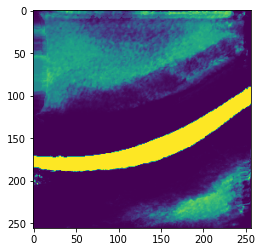

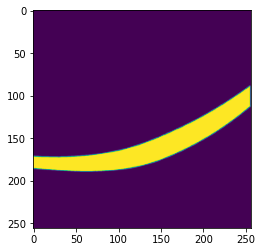

#Training [2 / 50] 0.92% loss = 0.03144 loss_acc = 0.04893 lr = 0.009989950403114326
#Training [2 / 50] 1.85% loss = 0.03861 loss_acc = 0.04890 lr = 0.00998976547985143
#Training [2 / 50] 2.77% loss = 0.02776 loss_acc = 0.05029 lr = 0.009989578872415117
#Training [2 / 50] 3.70% loss = 0.05135 loss_acc = 0.05034 lr = 0.009989390580868356
#Training [2 / 50] 4.62% loss = 0.03049 loss_acc = 0.04945 lr = 0.009989200605274706
#Training [2 / 50] 5.55% loss = 0.04221 loss_acc = 0.05022 lr = 0.009989008945698282
#Training [2 / 50] 6.47% loss = 0.09756 loss_acc = 0.05177 lr = 0.009988815602203785
#Training [2 / 50] 7.40% loss = 0.04254 loss_acc = 0.05271 lr = 0.009988620574856463
#Training [2 / 50] 8.32% loss = 0.04038 loss_acc = 0.05318 lr = 0.009988423863722149
#Training [2 / 50] 9.25% loss = 0.03602 loss_acc = 0.05234 lr = 0.009988225468867237
#Training [2 / 50] 10.17% loss = 0.04933 loss_acc = 0.05254 lr = 0.009988025390358691
#Training [2 / 50] 11.10% loss = 0.06464 loss_acc = 0.05193 lr = 

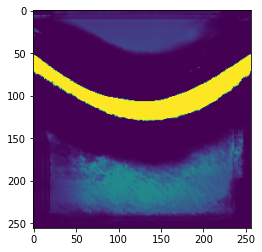

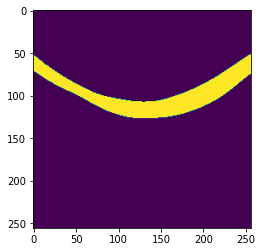

#Training [3 / 50] 0.92% loss = 0.04263 loss_acc = 0.04964 lr = 0.009960208595492953
#Training [3 / 50] 1.85% loss = 0.07156 loss_acc = 0.04614 lr = 0.00995984201021629
#Training [3 / 50] 2.77% loss = 0.17113 loss_acc = 0.04958 lr = 0.009959473750866131
#Training [3 / 50] 3.70% loss = 0.03671 loss_acc = 0.04796 lr = 0.009959103817566775
#Training [3 / 50] 4.62% loss = 0.06564 loss_acc = 0.04881 lr = 0.009958732210443084
#Training [3 / 50] 5.55% loss = 0.02847 loss_acc = 0.04874 lr = 0.00995835892962049
#Training [3 / 50] 6.47% loss = 0.04620 loss_acc = 0.04847 lr = 0.009957983975224979
#Training [3 / 50] 7.40% loss = 0.06408 loss_acc = 0.04790 lr = 0.009957607347383109
#Training [3 / 50] 8.32% loss = 0.03325 loss_acc = 0.04748 lr = 0.009957229046222005
#Training [3 / 50] 9.25% loss = 0.06461 loss_acc = 0.04773 lr = 0.009956849071869348
#Training [3 / 50] 10.17% loss = 0.04711 loss_acc = 0.04771 lr = 0.009956467424453394
#Training [3 / 50] 11.10% loss = 0.04379 loss_acc = 0.04761 lr = 0

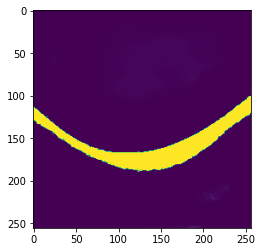

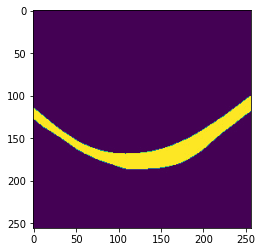

#Training [4 / 50] 0.92% loss = 0.07603 loss_acc = 0.06130 lr = 0.0099108911106489
#Training [4 / 50] 1.85% loss = 0.03076 loss_acc = 0.06096 lr = 0.009910344310103058
#Training [4 / 50] 2.77% loss = 0.05815 loss_acc = 0.06323 lr = 0.009909795852190468
#Training [4 / 50] 3.70% loss = 0.05500 loss_acc = 0.05880 lr = 0.009909245737096247
#Training [4 / 50] 4.62% loss = 0.05000 loss_acc = 0.05860 lr = 0.00990869396500607
#Training [4 / 50] 5.55% loss = 0.03632 loss_acc = 0.05711 lr = 0.009908140536106171
#Training [4 / 50] 6.47% loss = 0.03956 loss_acc = 0.05502 lr = 0.00990758545058335
#Training [4 / 50] 7.40% loss = 0.04606 loss_acc = 0.05505 lr = 0.00990702870862496
#Training [4 / 50] 8.32% loss = 0.04163 loss_acc = 0.05363 lr = 0.009906470310418915
#Training [4 / 50] 9.25% loss = 0.04835 loss_acc = 0.05350 lr = 0.009905910256153694
#Training [4 / 50] 10.17% loss = 0.04312 loss_acc = 0.05251 lr = 0.009905348546018327
#Training [4 / 50] 11.10% loss = 0.03056 loss_acc = 0.05190 lr = 0.00

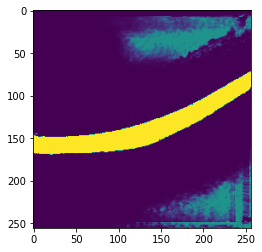

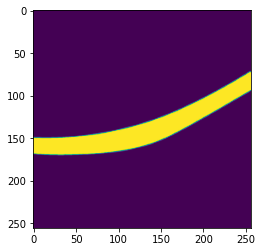

#Training [5 / 50] 0.92% loss = 0.06391 loss_acc = 0.06039 lr = 0.009842192582163914
#Training [5 / 50] 1.85% loss = 0.03437 loss_acc = 0.05372 lr = 0.009841467724320853
#Training [5 / 50] 2.77% loss = 0.05045 loss_acc = 0.05378 lr = 0.009840741232358648
#Training [5 / 50] 3.70% loss = 0.04619 loss_acc = 0.05410 lr = 0.009840013106522511
#Training [5 / 50] 4.62% loss = 0.05490 loss_acc = 0.05480 lr = 0.009839283347058195
#Training [5 / 50] 5.55% loss = 0.10372 loss_acc = 0.05380 lr = 0.00983855195421202
#Training [5 / 50] 6.47% loss = 0.04127 loss_acc = 0.05340 lr = 0.00983781892823085
#Training [5 / 50] 7.40% loss = 0.03702 loss_acc = 0.05322 lr = 0.009837084269362095
#Training [5 / 50] 8.32% loss = 0.04760 loss_acc = 0.05374 lr = 0.009836347977853729
#Training [5 / 50] 9.25% loss = 0.03523 loss_acc = 0.05374 lr = 0.009835610053954263
#Training [5 / 50] 10.17% loss = 0.05117 loss_acc = 0.05327 lr = 0.009834870497912769
#Training [5 / 50] 11.10% loss = 0.03867 loss_acc = 0.05316 lr = 0

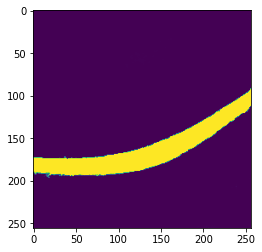

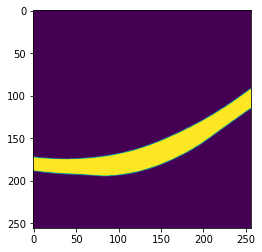

#Training [6 / 50] 0.92% loss = 0.05830 loss_acc = 0.05458 lr = 0.00975438413174451
#Training [6 / 50] 1.85% loss = 0.03881 loss_acc = 0.05304 lr = 0.009753484077286975
#Training [6 / 50] 2.77% loss = 0.04182 loss_acc = 0.05072 lr = 0.009752582418407034
#Training [6 / 50] 3.70% loss = 0.03875 loss_acc = 0.05099 lr = 0.009751679155409004
#Training [6 / 50] 4.62% loss = 0.05907 loss_acc = 0.05106 lr = 0.00975077428859777
#Training [6 / 50] 5.55% loss = 0.04909 loss_acc = 0.05043 lr = 0.009749867818278747
#Training [6 / 50] 6.47% loss = 0.04947 loss_acc = 0.05013 lr = 0.009748959744757889
#Training [6 / 50] 7.40% loss = 0.04714 loss_acc = 0.05088 lr = 0.009748050068341696
#Training [6 / 50] 8.32% loss = 0.03481 loss_acc = 0.05013 lr = 0.009747138789337206
#Training [6 / 50] 9.25% loss = 0.04451 loss_acc = 0.04951 lr = 0.009746225908051997
#Training [6 / 50] 10.17% loss = 0.04758 loss_acc = 0.04910 lr = 0.009745311424794196
#Training [6 / 50] 11.10% loss = 0.04517 loss_acc = 0.04872 lr = 0

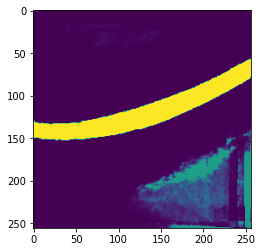

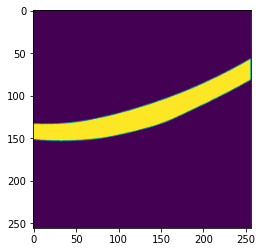

#Training [7 / 50] 0.92% loss = 0.04122 loss_acc = 0.04173 lr = 0.00964781229922858
#Training [7 / 50] 1.85% loss = 0.04044 loss_acc = 0.04145 lr = 0.009646740600260321
#Training [7 / 50] 2.77% loss = 0.05442 loss_acc = 0.04240 lr = 0.009645667332898305
#Training [7 / 50] 3.70% loss = 0.08048 loss_acc = 0.04299 lr = 0.009644592497504783
#Training [7 / 50] 4.62% loss = 0.04649 loss_acc = 0.04208 lr = 0.009643516094442535
#Training [7 / 50] 5.55% loss = 0.04250 loss_acc = 0.04177 lr = 0.00964243812407488
#Training [7 / 50] 6.47% loss = 0.04665 loss_acc = 0.04291 lr = 0.009641358586765666
#Training [7 / 50] 7.40% loss = 0.02776 loss_acc = 0.04243 lr = 0.009640277482879258
#Training [7 / 50] 8.32% loss = 0.03872 loss_acc = 0.04214 lr = 0.009639194812780555
#Training [7 / 50] 9.25% loss = 0.03277 loss_acc = 0.04272 lr = 0.009638110576834983
#Training [7 / 50] 10.17% loss = 0.04272 loss_acc = 0.04290 lr = 0.00963702477540851
#Training [7 / 50] 11.10% loss = 0.07356 loss_acc = 0.04311 lr = 0.

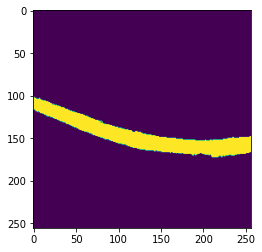

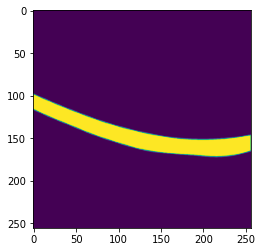

#Training [8 / 50] 0.92% loss = 0.04467 loss_acc = 0.04368 lr = 0.009522897674951014
#Training [8 / 50] 1.85% loss = 0.02495 loss_acc = 0.04485 lr = 0.009521658560978254
#Training [8 / 50] 2.77% loss = 0.05994 loss_acc = 0.04395 lr = 0.009520417920830115
#Training [8 / 50] 3.70% loss = 0.03911 loss_acc = 0.04422 lr = 0.009519175754925342
#Training [8 / 50] 4.62% loss = 0.09555 loss_acc = 0.04409 lr = 0.009517932063683213
#Training [8 / 50] 5.55% loss = 0.04667 loss_acc = 0.04425 lr = 0.009516686847523497
#Training [8 / 50] 6.47% loss = 0.06418 loss_acc = 0.04395 lr = 0.00951544010686649
#Training [8 / 50] 7.40% loss = 0.04524 loss_acc = 0.04401 lr = 0.009514191842132987
#Training [8 / 50] 8.32% loss = 0.03864 loss_acc = 0.04426 lr = 0.009512942053744327
#Training [8 / 50] 9.25% loss = 0.04289 loss_acc = 0.04447 lr = 0.009511690742122332
#Training [8 / 50] 10.17% loss = 0.04926 loss_acc = 0.04453 lr = 0.009510437907689353
#Training [8 / 50] 11.10% loss = 0.05579 loss_acc = 0.04434 lr = 

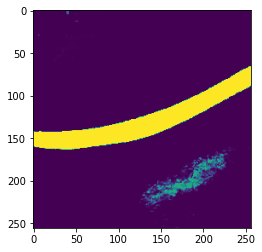

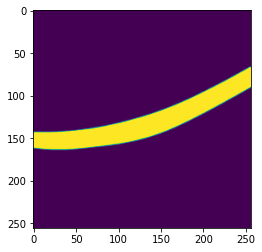

#Training [9 / 50] 0.92% loss = 0.04238 loss_acc = 0.04000 lr = 0.009380133239865847
#Training [9 / 50] 1.85% loss = 0.03679 loss_acc = 0.04087 lr = 0.009378731601105325
#Training [9 / 50] 2.77% loss = 0.05592 loss_acc = 0.04297 lr = 0.009377328484410934
#Training [9 / 50] 3.70% loss = 0.02490 loss_acc = 0.04249 lr = 0.009375923890256257
#Training [9 / 50] 4.62% loss = 0.04323 loss_acc = 0.04189 lr = 0.009374517819115384
#Training [9 / 50] 5.55% loss = 0.04336 loss_acc = 0.04169 lr = 0.009373110271462898
#Training [9 / 50] 6.47% loss = 0.02404 loss_acc = 0.04255 lr = 0.009371701247773888
#Training [9 / 50] 7.40% loss = 0.05895 loss_acc = 0.04214 lr = 0.009370290748523928
#Training [9 / 50] 8.32% loss = 0.04908 loss_acc = 0.04230 lr = 0.0093688787741891
#Training [9 / 50] 9.25% loss = 0.04839 loss_acc = 0.04266 lr = 0.009367465325245981
#Training [9 / 50] 10.17% loss = 0.06248 loss_acc = 0.04252 lr = 0.00936605040217165
#Training [9 / 50] 11.10% loss = 0.02564 loss_acc = 0.04266 lr = 0.

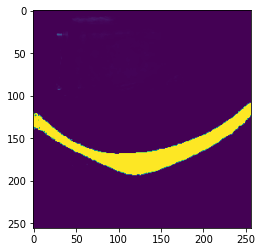

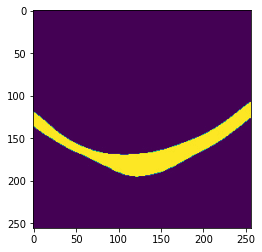

#Training [10 / 50] 0.92% loss = 0.03334 loss_acc = 0.04278 lr = 0.00922008241997546
#Training [10 / 50] 1.85% loss = 0.05171 loss_acc = 0.04281 lr = 0.009218523788055023
#Training [10 / 50] 2.77% loss = 0.04968 loss_acc = 0.04497 lr = 0.009216963732274947
#Training [10 / 50] 3.70% loss = 0.05498 loss_acc = 0.04415 lr = 0.009215402253161793
#Training [10 / 50] 4.62% loss = 0.03880 loss_acc = 0.04468 lr = 0.009213839351242594
#Training [10 / 50] 5.55% loss = 0.04876 loss_acc = 0.04532 lr = 0.009212275027044876
#Training [10 / 50] 6.47% loss = 0.03055 loss_acc = 0.04440 lr = 0.009210709281096637
#Training [10 / 50] 7.40% loss = 0.04856 loss_acc = 0.04466 lr = 0.009209142113926361
#Training [10 / 50] 8.32% loss = 0.02336 loss_acc = 0.04439 lr = 0.009207573526062999
#Training [10 / 50] 9.25% loss = 0.03832 loss_acc = 0.04393 lr = 0.00920600351803599
#Training [10 / 50] 10.17% loss = 0.09333 loss_acc = 0.04408 lr = 0.009204432090375253
#Training [10 / 50] 11.10% loss = 0.02848 loss_acc = 0.

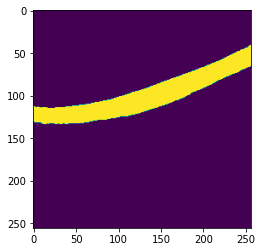

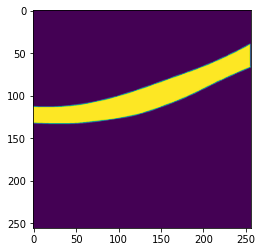

#Training [11 / 50] 0.92% loss = 0.05514 loss_acc = 0.04149 lr = 0.009043376862745697
#Training [11 / 50] 1.85% loss = 0.06816 loss_acc = 0.04194 lr = 0.009041667388873461
#Training [11 / 50] 2.77% loss = 0.08171 loss_acc = 0.04248 lr = 0.009039956550835143
#Training [11 / 50] 3.70% loss = 0.04517 loss_acc = 0.04045 lr = 0.009038244349208205
#Training [11 / 50] 4.62% loss = 0.03371 loss_acc = 0.03977 lr = 0.009036530784570541
#Training [11 / 50] 5.55% loss = 0.07058 loss_acc = 0.04010 lr = 0.009034815857500529
#Training [11 / 50] 6.47% loss = 0.03891 loss_acc = 0.04062 lr = 0.009033099568577006
#Training [11 / 50] 7.40% loss = 0.03415 loss_acc = 0.04108 lr = 0.009031381918379254
#Training [11 / 50] 8.32% loss = 0.06012 loss_acc = 0.04121 lr = 0.009029662907487034
#Training [11 / 50] 9.25% loss = 0.05462 loss_acc = 0.04123 lr = 0.009027942536480552
#Training [11 / 50] 10.17% loss = 0.07248 loss_acc = 0.04125 lr = 0.00902622080594048
#Training [11 / 50] 11.10% loss = 0.02763 loss_acc = 0

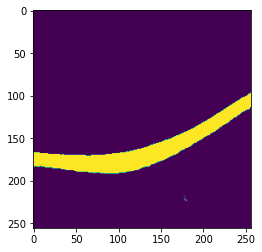

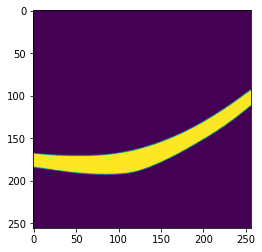

#Training [12 / 50] 0.92% loss = 0.04702 loss_acc = 0.03814 lr = 0.008850713944281864
#Training [12 / 50] 1.85% loss = 0.03612 loss_acc = 0.03796 lr = 0.00884886037497022
#Training [12 / 50] 2.77% loss = 0.02928 loss_acc = 0.03722 lr = 0.008847005506569793
#Training [12 / 50] 3.70% loss = 0.04144 loss_acc = 0.03770 lr = 0.008845149339706647
#Training [12 / 50] 4.62% loss = 0.03938 loss_acc = 0.03875 lr = 0.008843291875007288
#Training [12 / 50] 5.55% loss = 0.03208 loss_acc = 0.03908 lr = 0.008841433113098653
#Training [12 / 50] 6.47% loss = 0.08912 loss_acc = 0.04016 lr = 0.008839573054608127
#Training [12 / 50] 7.40% loss = 0.02220 loss_acc = 0.04008 lr = 0.008837711700163516
#Training [12 / 50] 8.32% loss = 0.02555 loss_acc = 0.03980 lr = 0.008835849050393089
#Training [12 / 50] 9.25% loss = 0.02931 loss_acc = 0.03979 lr = 0.00883398510592553
#Training [12 / 50] 10.17% loss = 0.03283 loss_acc = 0.03967 lr = 0.00883211986738997
#Training [12 / 50] 11.10% loss = 0.04503 loss_acc = 0.0

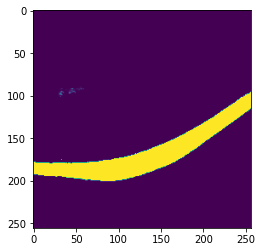

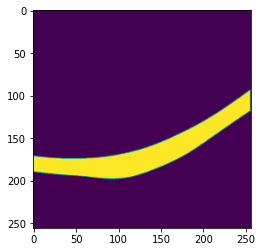

#Training [13 / 50] 0.92% loss = 0.02735 loss_acc = 0.04358 lr = 0.008642854017103779
#Training [13 / 50] 1.85% loss = 0.03352 loss_acc = 0.04438 lr = 0.008640863667543994
#Training [13 / 50] 2.77% loss = 0.03675 loss_acc = 0.04217 lr = 0.008638872089099628
#Training [13 / 50] 3.70% loss = 0.04788 loss_acc = 0.04206 lr = 0.008636879282442887
#Training [13 / 50] 4.62% loss = 0.05283 loss_acc = 0.04265 lr = 0.008634885248246403
#Training [13 / 50] 5.55% loss = 0.03005 loss_acc = 0.04287 lr = 0.008632889987183208
#Training [13 / 50] 6.47% loss = 0.03732 loss_acc = 0.04250 lr = 0.008630893499926757
#Training [13 / 50] 7.40% loss = 0.04383 loss_acc = 0.04164 lr = 0.008628895787150911
#Training [13 / 50] 8.32% loss = 0.04132 loss_acc = 0.04151 lr = 0.008626896849529959
#Training [13 / 50] 9.25% loss = 0.02777 loss_acc = 0.04100 lr = 0.008624896687738588
#Training [13 / 50] 10.17% loss = 0.03836 loss_acc = 0.04077 lr = 0.008622895302451904
#Training [13 / 50] 11.10% loss = 0.05786 loss_acc = 

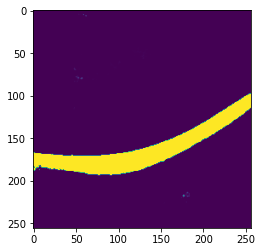

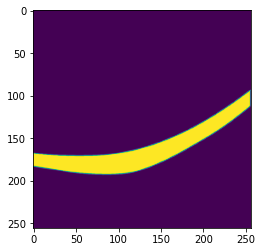

#Training [14 / 50] 0.92% loss = 0.03788 loss_acc = 0.04026 lr = 0.008420617409381879
#Training [14 / 50] 1.85% loss = 0.02683 loss_acc = 0.04373 lr = 0.008418498134574348
#Training [14 / 50] 2.77% loss = 0.03556 loss_acc = 0.04428 lr = 0.00841637770593629
#Training [14 / 50] 3.70% loss = 0.02935 loss_acc = 0.04337 lr = 0.008414256124183402
#Training [14 / 50] 4.62% loss = 0.03172 loss_acc = 0.04292 lr = 0.008412133390031776
#Training [14 / 50] 5.55% loss = 0.03032 loss_acc = 0.04191 lr = 0.008410009504197891
#Training [14 / 50] 6.47% loss = 0.02798 loss_acc = 0.04142 lr = 0.008407884467398617
#Training [14 / 50] 7.40% loss = 0.05386 loss_acc = 0.04157 lr = 0.008405758280351195
#Training [14 / 50] 8.32% loss = 0.03209 loss_acc = 0.04103 lr = 0.008403630943773274
#Training [14 / 50] 9.25% loss = 0.03175 loss_acc = 0.04063 lr = 0.008401502458382887
#Training [14 / 50] 10.17% loss = 0.03845 loss_acc = 0.04124 lr = 0.008399372824898452
#Training [14 / 50] 11.10% loss = 0.03103 loss_acc = 0

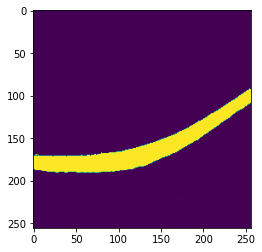

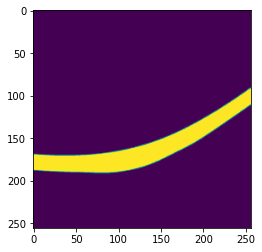

#Training [15 / 50] 0.92% loss = 0.03997 loss_acc = 0.04550 lr = 0.008184881187476591
#Training [15 / 50] 1.85% loss = 0.03769 loss_acc = 0.04633 lr = 0.008182641351230775
#Training [15 / 50] 2.77% loss = 0.07118 loss_acc = 0.04451 lr = 0.008180400440762127
#Training [15 / 50] 3.70% loss = 0.02960 loss_acc = 0.04274 lr = 0.008178158456827017
#Training [15 / 50] 4.62% loss = 0.03461 loss_acc = 0.04267 lr = 0.008175915400182168
#Training [15 / 50] 5.55% loss = 0.06582 loss_acc = 0.04246 lr = 0.008173671271584667
#Training [15 / 50] 6.47% loss = 0.01859 loss_acc = 0.04198 lr = 0.008171426071791969
#Training [15 / 50] 7.40% loss = 0.02319 loss_acc = 0.04175 lr = 0.008169179801561885
#Training [15 / 50] 8.32% loss = 0.02589 loss_acc = 0.04192 lr = 0.008166932461652588
#Training [15 / 50] 9.25% loss = 0.03391 loss_acc = 0.04197 lr = 0.008164684052822615
#Training [15 / 50] 10.17% loss = 0.03059 loss_acc = 0.04176 lr = 0.008162434575830858
#Training [15 / 50] 11.10% loss = 0.03105 loss_acc = 

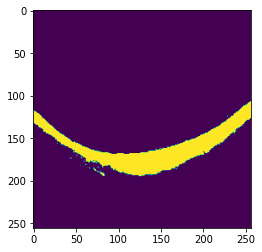

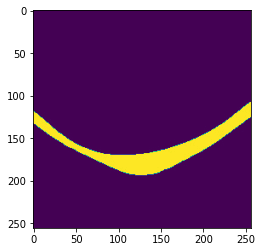

#Training [16 / 50] 0.92% loss = 0.05088 loss_acc = 0.04071 lr = 0.007936575694558216
#Training [16 / 50] 1.85% loss = 0.03204 loss_acc = 0.04130 lr = 0.007934224136484496
#Training [16 / 50] 2.77% loss = 0.02894 loss_acc = 0.04006 lr = 0.007931871588035107
#Training [16 / 50] 3.70% loss = 0.05165 loss_acc = 0.04192 lr = 0.007929518050004096
#Training [16 / 50] 4.62% loss = 0.06232 loss_acc = 0.04334 lr = 0.007927163523185845
#Training [16 / 50] 5.55% loss = 0.02660 loss_acc = 0.04237 lr = 0.007924808008375058
#Training [16 / 50] 6.47% loss = 0.03478 loss_acc = 0.04210 lr = 0.007922451506366788
#Training [16 / 50] 7.40% loss = 0.04738 loss_acc = 0.04200 lr = 0.007920094017956413
#Training [16 / 50] 8.32% loss = 0.02441 loss_acc = 0.04195 lr = 0.007917735543939649
#Training [16 / 50] 9.25% loss = 0.05838 loss_acc = 0.04175 lr = 0.00791537608511253
#Training [16 / 50] 10.17% loss = 0.03287 loss_acc = 0.04147 lr = 0.007913015642271445
#Training [16 / 50] 11.10% loss = 0.03674 loss_acc = 0

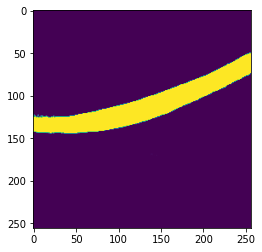

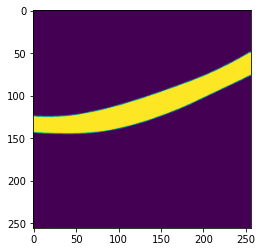

#Training [17 / 50] 0.92% loss = 0.04232 loss_acc = 0.03764 lr = 0.00767668087896716
#Training [17 / 50] 1.85% loss = 0.03877 loss_acc = 0.03856 lr = 0.0076742268795909315
#Training [17 / 50] 2.77% loss = 0.03311 loss_acc = 0.03867 lr = 0.007671771977594756
#Training [17 / 50] 3.70% loss = 0.03835 loss_acc = 0.03786 lr = 0.007669316173807227
#Training [17 / 50] 4.62% loss = 0.02541 loss_acc = 0.03919 lr = 0.007666859469057237
#Training [17 / 50] 5.55% loss = 0.03864 loss_acc = 0.03930 lr = 0.00766440186417399
#Training [17 / 50] 6.47% loss = 0.03353 loss_acc = 0.03918 lr = 0.007661943359986991
#Training [17 / 50] 7.40% loss = 0.03483 loss_acc = 0.03893 lr = 0.007659483957326046
#Training [17 / 50] 8.32% loss = 0.02974 loss_acc = 0.04020 lr = 0.007657023657021266
#Training [17 / 50] 9.25% loss = 0.04823 loss_acc = 0.04043 lr = 0.00765456245990307
#Training [17 / 50] 10.17% loss = 0.02869 loss_acc = 0.04066 lr = 0.00765210036680217
#Training [17 / 50] 11.10% loss = 0.03598 loss_acc = 0.0

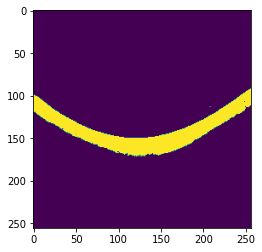

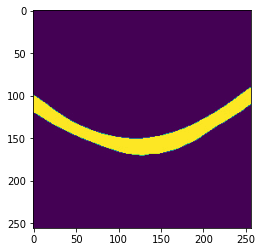

#Training [18 / 50] 0.92% loss = 0.04857 loss_acc = 0.04636 lr = 0.007406222426805988
#Training [18 / 50] 1.85% loss = 0.03323 loss_acc = 0.04238 lr = 0.007403675670941661
#Training [18 / 50] 2.77% loss = 0.03883 loss_acc = 0.03952 lr = 0.007401128103775338
#Training [18 / 50] 3.70% loss = 0.04594 loss_acc = 0.03892 lr = 0.0073985797261668885
#Training [18 / 50] 4.62% loss = 0.05969 loss_acc = 0.03899 lr = 0.007396030538976451
#Training [18 / 50] 5.55% loss = 0.04871 loss_acc = 0.04038 lr = 0.007393480543064445
#Training [18 / 50] 6.47% loss = 0.03550 loss_acc = 0.03951 lr = 0.00739092973929156
#Training [18 / 50] 7.40% loss = 0.02693 loss_acc = 0.03894 lr = 0.007388378128518754
#Training [18 / 50] 8.32% loss = 0.03391 loss_acc = 0.03848 lr = 0.007385825711607265
#Training [18 / 50] 9.25% loss = 0.03070 loss_acc = 0.03823 lr = 0.0073832724894186
#Training [18 / 50] 10.17% loss = 0.03898 loss_acc = 0.03809 lr = 0.007380718462814532
#Training [18 / 50] 11.10% loss = 0.03285 loss_acc = 0.

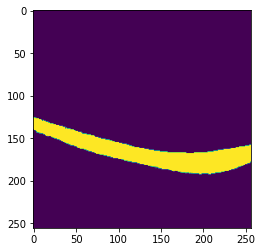

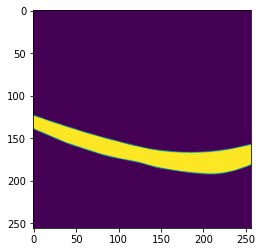

#Training [19 / 50] 0.92% loss = 0.03695 loss_acc = 0.04686 lr = 0.0071262677140246965
#Training [19 / 50] 1.85% loss = 0.04257 loss_acc = 0.04194 lr = 0.0071236382525541675
#Training [19 / 50] 2.77% loss = 0.02933 loss_acc = 0.04044 lr = 0.007121008074301429
#Training [19 / 50] 3.70% loss = 0.03359 loss_acc = 0.03888 lr = 0.007118377180154235
#Training [19 / 50] 4.62% loss = 0.07480 loss_acc = 0.03861 lr = 0.007115745571000581
#Training [19 / 50] 5.55% loss = 0.03170 loss_acc = 0.03805 lr = 0.0071131132477287
#Training [19 / 50] 6.47% loss = 0.05861 loss_acc = 0.03802 lr = 0.0071104802112270694
#Training [19 / 50] 7.40% loss = 0.05281 loss_acc = 0.03819 lr = 0.007107846462384405
#Training [19 / 50] 8.32% loss = 0.04479 loss_acc = 0.03819 lr = 0.007105212002089671
#Training [19 / 50] 9.25% loss = 0.03170 loss_acc = 0.03863 lr = 0.007102576831232057
#Training [19 / 50] 10.17% loss = 0.02704 loss_acc = 0.03830 lr = 0.007099940950701002
#Training [19 / 50] 11.10% loss = 0.02659 loss_acc =

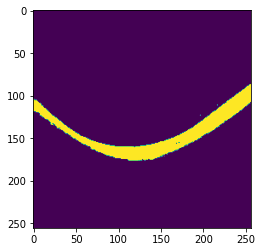

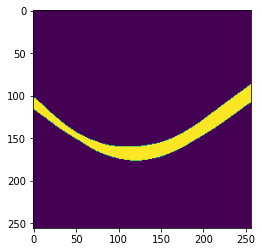

#Training [20 / 50] 0.92% loss = 0.05034 loss_acc = 0.03752 lr = 0.006837921593975466
#Training [20 / 50] 1.85% loss = 0.04719 loss_acc = 0.03973 lr = 0.006835219804181867
#Training [20 / 50] 2.77% loss = 0.03387 loss_acc = 0.03996 lr = 0.006832517394954664
#Training [20 / 50] 3.70% loss = 0.02799 loss_acc = 0.04069 lr = 0.006829814367205985
#Training [20 / 50] 4.62% loss = 0.03365 loss_acc = 0.04118 lr = 0.006827110721848173
#Training [20 / 50] 5.55% loss = 0.04388 loss_acc = 0.04109 lr = 0.006824406459793774
#Training [20 / 50] 6.47% loss = 0.03139 loss_acc = 0.04018 lr = 0.006821701581955549
#Training [20 / 50] 7.40% loss = 0.03362 loss_acc = 0.04014 lr = 0.006818996089246465
#Training [20 / 50] 8.32% loss = 0.04177 loss_acc = 0.03989 lr = 0.0068162899825796935
#Training [20 / 50] 9.25% loss = 0.06339 loss_acc = 0.04039 lr = 0.006813583262868611
#Training [20 / 50] 10.17% loss = 0.03751 loss_acc = 0.03999 lr = 0.006810875931026807
#Training [20 / 50] 11.10% loss = 0.02877 loss_acc =

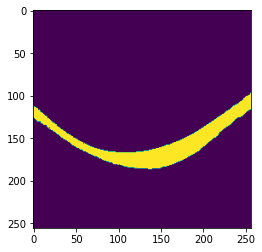

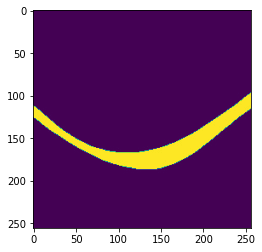

#Training [21 / 50] 0.92% loss = 0.03966 loss_acc = 0.03553 lr = 0.00654232203706133
#Training [21 / 50] 1.85% loss = 0.03810 loss_acc = 0.04086 lr = 0.00653955858167465
#Training [21 / 50] 2.77% loss = 0.03282 loss_acc = 0.04123 lr = 0.006536794606647585
#Training [21 / 50] 3.70% loss = 0.04157 loss_acc = 0.04026 lr = 0.0065340301129130475
#Training [21 / 50] 4.62% loss = 0.03087 loss_acc = 0.03998 lr = 0.006531265101404127
#Training [21 / 50] 5.55% loss = 0.02650 loss_acc = 0.03934 lr = 0.006528499573054083
#Training [21 / 50] 6.47% loss = 0.02782 loss_acc = 0.03905 lr = 0.006525733528796346
#Training [21 / 50] 7.40% loss = 0.03282 loss_acc = 0.03860 lr = 0.006522966969564539
#Training [21 / 50] 8.32% loss = 0.03246 loss_acc = 0.03890 lr = 0.00652019989629244
#Training [21 / 50] 9.25% loss = 0.05004 loss_acc = 0.03883 lr = 0.006517432309914008
#Training [21 / 50] 10.17% loss = 0.02404 loss_acc = 0.03910 lr = 0.006514664211363371
#Training [21 / 50] 11.10% loss = 0.04978 loss_acc = 0.

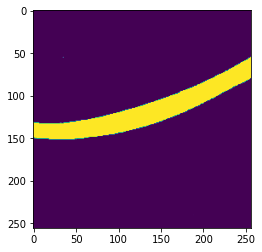

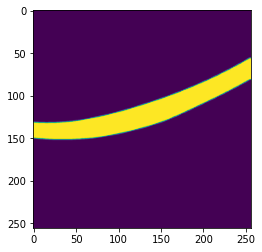

#Training [22 / 50] 0.92% loss = 0.02745 loss_acc = 0.03357 lr = 0.006240635639686806
#Training [22 / 50] 1.85% loss = 0.06167 loss_acc = 0.03763 lr = 0.006237821424802956
#Training [22 / 50] 2.77% loss = 0.03722 loss_acc = 0.03835 lr = 0.006235006792122724
#Training [22 / 50] 3.70% loss = 0.04191 loss_acc = 0.04045 lr = 0.006232191742596127
#Training [22 / 50] 4.62% loss = 0.05149 loss_acc = 0.04040 lr = 0.006229376277173309
#Training [22 / 50] 5.55% loss = 0.03153 loss_acc = 0.03955 lr = 0.0062265603968045665
#Training [22 / 50] 6.47% loss = 0.03060 loss_acc = 0.03945 lr = 0.006223744102440326
#Training [22 / 50] 7.40% loss = 0.04691 loss_acc = 0.03893 lr = 0.006220927395031163
#Training [22 / 50] 8.32% loss = 0.03141 loss_acc = 0.03873 lr = 0.006218110275527787
#Training [22 / 50] 9.25% loss = 0.02357 loss_acc = 0.03846 lr = 0.006215292744881051
#Training [22 / 50] 10.17% loss = 0.04601 loss_acc = 0.03825 lr = 0.006212474804041938
#Training [22 / 50] 11.10% loss = 0.05639 loss_acc =

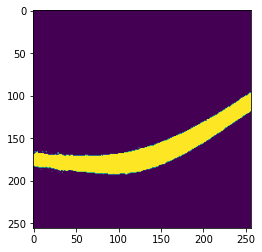

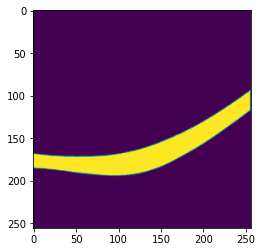

#Training [23 / 50] 0.92% loss = 0.03121 loss_acc = 0.03788 lr = 0.005934053020234952
#Training [23 / 50] 1.85% loss = 0.03125 loss_acc = 0.03965 lr = 0.005931199152274382
#Training [23 / 50] 2.77% loss = 0.02902 loss_acc = 0.03954 lr = 0.005928344970010291
#Training [23 / 50] 3.70% loss = 0.03219 loss_acc = 0.03857 lr = 0.005925490474406035
#Training [23 / 50] 4.62% loss = 0.03958 loss_acc = 0.03966 lr = 0.00592263566642508
#Training [23 / 50] 5.55% loss = 0.02607 loss_acc = 0.03895 lr = 0.005919780547030997
#Training [23 / 50] 6.47% loss = 0.03556 loss_acc = 0.03902 lr = 0.005916925117187461
#Training [23 / 50] 7.40% loss = 0.04223 loss_acc = 0.03981 lr = 0.005914069377858257
#Training [23 / 50] 8.32% loss = 0.04387 loss_acc = 0.03961 lr = 0.0059112133300072665
#Training [23 / 50] 9.25% loss = 0.02744 loss_acc = 0.03913 lr = 0.005908356974598478
#Training [23 / 50] 10.17% loss = 0.04539 loss_acc = 0.03905 lr = 0.005905500312595987
#Training [23 / 50] 11.10% loss = 0.02488 loss_acc = 

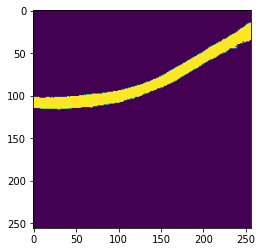

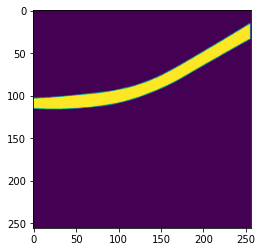

#Training [24 / 50] 0.92% loss = 0.03147 loss_acc = 0.03961 lr = 0.005623784120240475
#Training [24 / 50] 1.85% loss = 0.03183 loss_acc = 0.03864 lr = 0.0056209018621162215
#Training [24 / 50] 2.77% loss = 0.03434 loss_acc = 0.03965 lr = 0.005618019394421711
#Training [24 / 50] 3.70% loss = 0.03808 loss_acc = 0.04003 lr = 0.005615136718129853
#Training [24 / 50] 4.62% loss = 0.03296 loss_acc = 0.03971 lr = 0.005612253834213626
#Training [24 / 50] 5.55% loss = 0.02605 loss_acc = 0.03862 lr = 0.005609370743646077
#Training [24 / 50] 6.47% loss = 0.03072 loss_acc = 0.03878 lr = 0.005606487447400318
#Training [24 / 50] 7.40% loss = 0.02646 loss_acc = 0.03943 lr = 0.005603603946449541
#Training [24 / 50] 8.32% loss = 0.03250 loss_acc = 0.04016 lr = 0.005600720241766995
#Training [24 / 50] 9.25% loss = 0.04342 loss_acc = 0.04052 lr = 0.005597836334326011
#Training [24 / 50] 10.17% loss = 0.04183 loss_acc = 0.04012 lr = 0.005594952225099978
#Training [24 / 50] 11.10% loss = 0.02554 loss_acc =

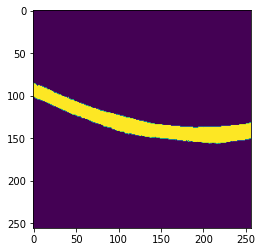

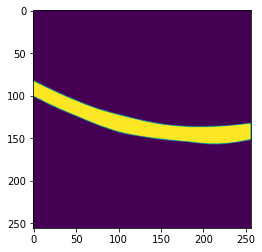

#Training [25 / 50] 0.92% loss = 0.03383 loss_acc = 0.03666 lr = 0.005311053429303248
#Training [25 / 50] 1.85% loss = 0.04118 loss_acc = 0.03519 lr = 0.0053081541559713424
#Training [25 / 50] 2.77% loss = 0.04013 loss_acc = 0.03546 lr = 0.005305254778629529
#Training [25 / 50] 3.70% loss = 0.03028 loss_acc = 0.03433 lr = 0.005302355298256425
#Training [25 / 50] 4.62% loss = 0.03544 loss_acc = 0.03523 lr = 0.005299455715830677
#Training [25 / 50] 5.55% loss = 0.03620 loss_acc = 0.03567 lr = 0.0052965560323309695
#Training [25 / 50] 6.47% loss = 0.03607 loss_acc = 0.03660 lr = 0.005293656248736016
#Training [25 / 50] 7.40% loss = 0.03948 loss_acc = 0.03702 lr = 0.005290756366024572
#Training [25 / 50] 8.32% loss = 0.02466 loss_acc = 0.03687 lr = 0.005287856385175419
#Training [25 / 50] 9.25% loss = 0.06595 loss_acc = 0.03752 lr = 0.005284956307167377
#Training [25 / 50] 10.17% loss = 0.03019 loss_acc = 0.03749 lr = 0.005282056132979295
#Training [25 / 50] 11.10% loss = 0.03655 loss_acc 

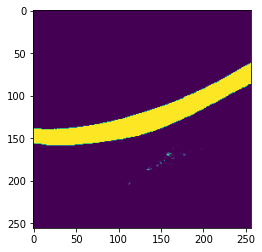

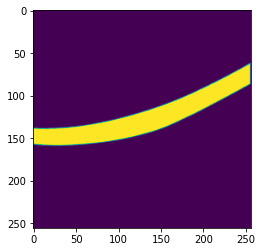

#Training [26 / 50] 0.92% loss = 0.04225 loss_acc = 0.03924 lr = 0.004997095152587354
#Training [26 / 50] 1.85% loss = 0.04111 loss_acc = 0.03848 lr = 0.004994190306155093
#Training [26 / 50] 2.77% loss = 0.03416 loss_acc = 0.03909 lr = 0.004991285461683745
#Training [26 / 50] 3.70% loss = 0.03379 loss_acc = 0.03732 lr = 0.0049883806201537805
#Training [26 / 50] 4.62% loss = 0.03016 loss_acc = 0.03645 lr = 0.004985475782545651
#Training [26 / 50] 5.55% loss = 0.03758 loss_acc = 0.03667 lr = 0.00498257094983982
#Training [26 / 50] 6.47% loss = 0.04013 loss_acc = 0.03670 lr = 0.004979666123016736
#Training [26 / 50] 7.40% loss = 0.02632 loss_acc = 0.03649 lr = 0.004976761303056859
#Training [26 / 50] 8.32% loss = 0.02843 loss_acc = 0.03637 lr = 0.004973856490940634
#Training [26 / 50] 9.25% loss = 0.02898 loss_acc = 0.03636 lr = 0.004970951687648516
#Training [26 / 50] 10.17% loss = 0.02726 loss_acc = 0.03636 lr = 0.004968046894160941
#Training [26 / 50] 11.10% loss = 0.02888 loss_acc = 

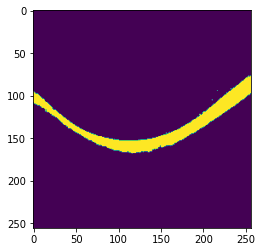

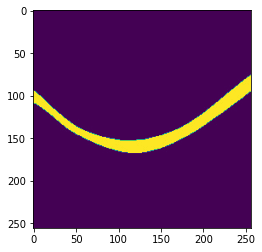

#Training [27 / 50] 0.92% loss = 0.05161 loss_acc = 0.03805 lr = 0.00468314833997712
#Training [27 / 50] 1.85% loss = 0.03862 loss_acc = 0.03956 lr = 0.004680249384546267
#Training [27 / 50] 2.77% loss = 0.04805 loss_acc = 0.04057 lr = 0.004677350537039422
#Training [27 / 50] 3.70% loss = 0.02647 loss_acc = 0.03950 lr = 0.004674451798435018
#Training [27 / 50] 4.62% loss = 0.02460 loss_acc = 0.03943 lr = 0.004671553169711458
#Training [27 / 50] 5.55% loss = 0.03831 loss_acc = 0.03930 lr = 0.004668654651847101
#Training [27 / 50] 6.47% loss = 0.02403 loss_acc = 0.03913 lr = 0.004665756245820269
#Training [27 / 50] 7.40% loss = 0.03138 loss_acc = 0.03908 lr = 0.0046628579526092504
#Training [27 / 50] 8.32% loss = 0.03241 loss_acc = 0.03859 lr = 0.00465995977319229
#Training [27 / 50] 9.25% loss = 0.02755 loss_acc = 0.03864 lr = 0.004657061708547604
#Training [27 / 50] 10.17% loss = 0.02329 loss_acc = 0.03863 lr = 0.004654163759653359
#Training [27 / 50] 11.10% loss = 0.02531 loss_acc = 0

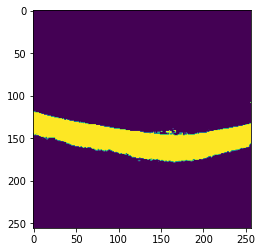

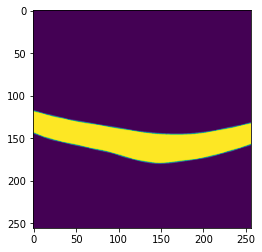

#Training [28 / 50] 0.92% loss = 0.04465 loss_acc = 0.03889 lr = 0.004370451996113224
#Training [28 / 50] 1.85% loss = 0.02841 loss_acc = 0.03703 lr = 0.004367570372536459
#Training [28 / 50] 2.77% loss = 0.04774 loss_acc = 0.04020 lr = 0.004364688962420862
#Training [28 / 50] 3.70% loss = 0.04435 loss_acc = 0.04015 lr = 0.0043618077667389845
#Training [28 / 50] 4.62% loss = 0.04486 loss_acc = 0.03987 lr = 0.004358926786463302
#Training [28 / 50] 5.55% loss = 0.04258 loss_acc = 0.04026 lr = 0.004356046022566225
#Training [28 / 50] 6.47% loss = 0.02536 loss_acc = 0.03973 lr = 0.004353165476020075
#Training [28 / 50] 7.40% loss = 0.02995 loss_acc = 0.03949 lr = 0.004350285147797118
#Training [28 / 50] 8.32% loss = 0.02771 loss_acc = 0.03946 lr = 0.004347405038869535
#Training [28 / 50] 9.25% loss = 0.04343 loss_acc = 0.03919 lr = 0.004344525150209439
#Training [28 / 50] 10.17% loss = 0.03043 loss_acc = 0.03890 lr = 0.00434164548278886
#Training [28 / 50] 11.10% loss = 0.01799 loss_acc = 

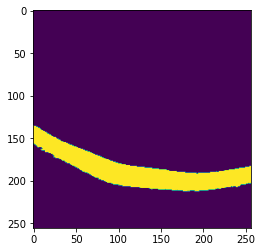

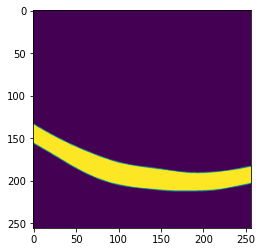

#Training [29 / 50] 0.92% loss = 0.02940 loss_acc = 0.03862 lr = 0.004060240190607557
#Training [29 / 50] 1.85% loss = 0.03134 loss_acc = 0.03675 lr = 0.004057387271336652
#Training [29 / 50] 2.77% loss = 0.03603 loss_acc = 0.03873 lr = 0.004054534670221643
#Training [29 / 50] 3.70% loss = 0.02685 loss_acc = 0.03937 lr = 0.004051682388225355
#Training [29 / 50] 4.62% loss = 0.01750 loss_acc = 0.03895 lr = 0.004048830426310508
#Training [29 / 50] 5.55% loss = 0.03025 loss_acc = 0.03927 lr = 0.004045978785439712
#Training [29 / 50] 6.47% loss = 0.03097 loss_acc = 0.03935 lr = 0.004043127466575469
#Training [29 / 50] 7.40% loss = 0.02946 loss_acc = 0.03930 lr = 0.004040276470680172
#Training [29 / 50] 8.32% loss = 0.05887 loss_acc = 0.03953 lr = 0.004037425798716102
#Training [29 / 50] 9.25% loss = 0.08464 loss_acc = 0.03987 lr = 0.004034575451645439
#Training [29 / 50] 10.17% loss = 0.03678 loss_acc = 0.03950 lr = 0.004031725430430245
#Training [29 / 50] 11.10% loss = 0.03521 loss_acc = 

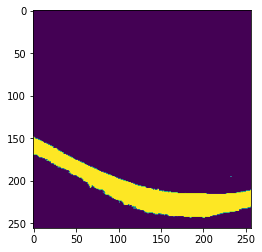

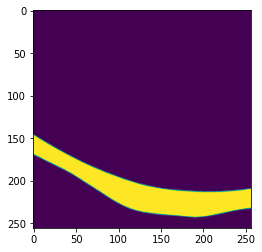

#Training [30 / 50] 0.92% loss = 0.03718 loss_acc = 0.03555 lr = 0.003753737187734147
#Training [30 / 50] 1.85% loss = 0.05154 loss_acc = 0.03751 lr = 0.003750924231938086
#Training [30 / 50] 2.77% loss = 0.03604 loss_acc = 0.03863 lr = 0.0037481116977370332
#Training [30 / 50] 3.70% loss = 0.02723 loss_acc = 0.03922 lr = 0.0037452995860802916
#Training [30 / 50] 4.62% loss = 0.03204 loss_acc = 0.03907 lr = 0.0037424878979170195
#Training [30 / 50] 5.55% loss = 0.04014 loss_acc = 0.03842 lr = 0.003739676634196232
#Training [30 / 50] 6.47% loss = 0.05061 loss_acc = 0.03821 lr = 0.0037368657958668046
#Training [30 / 50] 7.40% loss = 0.02619 loss_acc = 0.03807 lr = 0.0037340553838774685
#Training [30 / 50] 8.32% loss = 0.04509 loss_acc = 0.03817 lr = 0.003731245399176808
#Training [30 / 50] 9.25% loss = 0.04957 loss_acc = 0.03775 lr = 0.0037284358427132672
#Training [30 / 50] 10.17% loss = 0.03007 loss_acc = 0.03755 lr = 0.003725626715435138
#Training [30 / 50] 11.10% loss = 0.03593 loss_

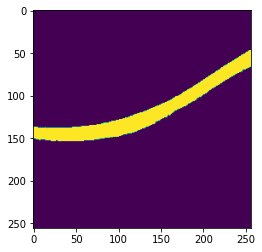

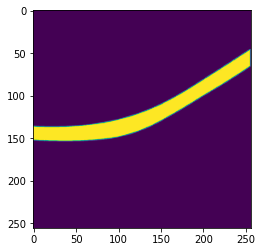

#Training [31 / 50] 0.92% loss = 0.02653 loss_acc = 0.03401 lr = 0.0034521526148174244
#Training [31 / 50] 1.85% loss = 0.01709 loss_acc = 0.03464 lr = 0.00344939072394762
#Training [31 / 50] 2.77% loss = 0.06313 loss_acc = 0.03673 lr = 0.003446629356448088
#Training [31 / 50] 3.70% loss = 0.02002 loss_acc = 0.03565 lr = 0.003443868513250871
#Training [31 / 50] 4.62% loss = 0.02751 loss_acc = 0.03715 lr = 0.003441108195287814
#Training [31 / 50] 5.55% loss = 0.03536 loss_acc = 0.03756 lr = 0.0034383484034906024
#Training [31 / 50] 6.47% loss = 0.04536 loss_acc = 0.03720 lr = 0.003435589138790731
#Training [31 / 50] 7.40% loss = 0.02714 loss_acc = 0.03741 lr = 0.0034328304021195243
#Training [31 / 50] 8.32% loss = 0.04103 loss_acc = 0.03706 lr = 0.0034300721944081273
#Training [31 / 50] 9.25% loss = 0.02476 loss_acc = 0.03725 lr = 0.0034273145165875044
#Training [31 / 50] 10.17% loss = 0.03324 loss_acc = 0.03718 lr = 0.003424557369588441
#Training [31 / 50] 11.10% loss = 0.03026 loss_ac

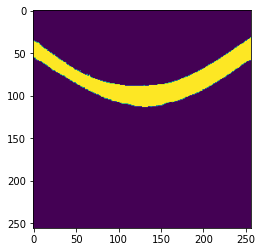

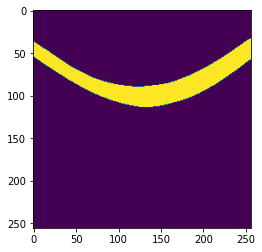

#Training [32 / 50] 0.92% loss = 0.06082 loss_acc = 0.03506 lr = 0.003156676688385816
#Training [32 / 50] 1.85% loss = 0.03092 loss_acc = 0.03604 lr = 0.003153976762363742
#Training [32 / 50] 2.77% loss = 0.03799 loss_acc = 0.03680 lr = 0.0031512774594217095
#Training [32 / 50] 3.70% loss = 0.01905 loss_acc = 0.03646 lr = 0.0031485787804708034
#Training [32 / 50] 4.62% loss = 0.03380 loss_acc = 0.03725 lr = 0.003145880726421895
#Training [32 / 50] 5.55% loss = 0.02647 loss_acc = 0.03687 lr = 0.003143183298185649
#Training [32 / 50] 6.47% loss = 0.02494 loss_acc = 0.03702 lr = 0.0031404864966725126
#Training [32 / 50] 7.40% loss = 0.03370 loss_acc = 0.03766 lr = 0.003137790322792731
#Training [32 / 50] 8.32% loss = 0.04230 loss_acc = 0.03711 lr = 0.0031350947774563265
#Training [32 / 50] 9.25% loss = 0.05403 loss_acc = 0.03715 lr = 0.0031323998615731185
#Training [32 / 50] 10.17% loss = 0.04251 loss_acc = 0.03722 lr = 0.0031297055760527073
#Training [32 / 50] 11.10% loss = 0.03302 loss_

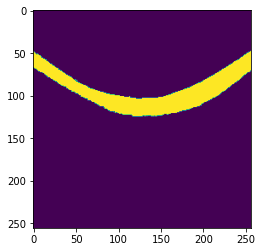

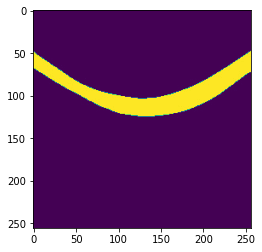

#Training [33 / 50] 0.92% loss = 0.02782 loss_acc = 0.03567 lr = 0.0028684755169308264
#Training [33 / 50] 1.85% loss = 0.05714 loss_acc = 0.03683 lr = 0.002865848211131014
#Training [33 / 50] 2.77% loss = 0.03178 loss_acc = 0.03707 lr = 0.002863221625661995
#Training [33 / 50] 3.70% loss = 0.02961 loss_acc = 0.03671 lr = 0.0028605957614103107
#Training [33 / 50] 4.62% loss = 0.02417 loss_acc = 0.03668 lr = 0.0028579706192622583
#Training [33 / 50] 5.55% loss = 0.04600 loss_acc = 0.03712 lr = 0.0028553462001038882
#Training [33 / 50] 6.47% loss = 0.03580 loss_acc = 0.03658 lr = 0.00285272250482101
#Training [33 / 50] 7.40% loss = 0.02683 loss_acc = 0.03703 lr = 0.0028500995342991913
#Training [33 / 50] 8.32% loss = 0.04281 loss_acc = 0.03774 lr = 0.002847477289423744
#Training [33 / 50] 9.25% loss = 0.02626 loss_acc = 0.03742 lr = 0.002844855771079752
#Training [33 / 50] 10.17% loss = 0.06245 loss_acc = 0.03756 lr = 0.0028422349801520376
#Training [33 / 50] 11.10% loss = 0.04419 loss_a

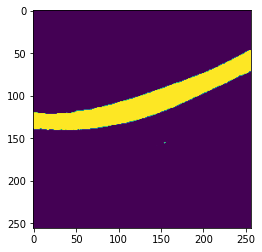

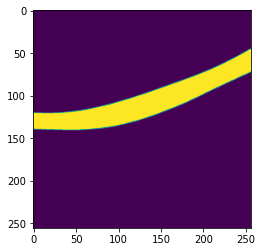

#Training [34 / 50] 0.92% loss = 0.03136 loss_acc = 0.03062 lr = 0.0025886864988096257
#Training [34 / 50] 1.85% loss = 0.03416 loss_acc = 0.03502 lr = 0.002586142182007763
#Training [34 / 50] 2.77% loss = 0.03995 loss_acc = 0.03525 lr = 0.0025835986799446326
#Training [34 / 50] 3.70% loss = 0.08071 loss_acc = 0.03558 lr = 0.00258105599347873
#Training [34 / 50] 4.62% loss = 0.02912 loss_acc = 0.03440 lr = 0.0025785141234682765
#Training [34 / 50] 5.55% loss = 0.03213 loss_acc = 0.03486 lr = 0.0025759730707712205
#Training [34 / 50] 6.47% loss = 0.03831 loss_acc = 0.03529 lr = 0.002573432836245228
#Training [34 / 50] 7.40% loss = 0.03351 loss_acc = 0.03560 lr = 0.0025708934207476996
#Training [34 / 50] 8.32% loss = 0.04539 loss_acc = 0.03590 lr = 0.0025683548251357467
#Training [34 / 50] 9.25% loss = 0.07428 loss_acc = 0.03580 lr = 0.002565817050266215
#Training [34 / 50] 10.17% loss = 0.05224 loss_acc = 0.03581 lr = 0.0025632800969956657
#Training [34 / 50] 11.10% loss = 0.04151 loss_

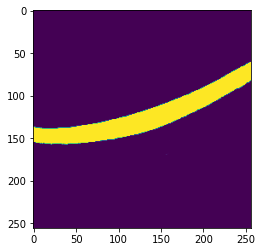

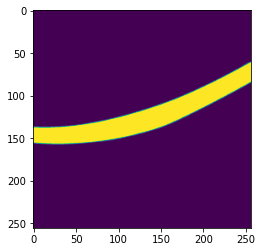

#Training [35 / 50] 0.92% loss = 0.02841 loss_acc = 0.03541 lr = 0.0023184138334532613
#Training [35 / 50] 1.85% loss = 0.04123 loss_acc = 0.03480 lr = 0.0023159625469053786
#Training [35 / 50] 2.77% loss = 0.04606 loss_acc = 0.03544 lr = 0.002313512166288761
#Training [35 / 50] 3.70% loss = 0.02734 loss_acc = 0.03473 lr = 0.0023110626924304767
#Training [35 / 50] 4.62% loss = 0.03512 loss_acc = 0.03402 lr = 0.0023086141261572856
#Training [35 / 50] 5.55% loss = 0.03616 loss_acc = 0.03538 lr = 0.002306166468295641
#Training [35 / 50] 6.47% loss = 0.02319 loss_acc = 0.03502 lr = 0.0023037197196716886
#Training [35 / 50] 7.40% loss = 0.02178 loss_acc = 0.03466 lr = 0.0023012738811112685
#Training [35 / 50] 8.32% loss = 0.03069 loss_acc = 0.03483 lr = 0.0022988289534399157
#Training [35 / 50] 9.25% loss = 0.02298 loss_acc = 0.03490 lr = 0.002296384937482855
#Training [35 / 50] 10.17% loss = 0.01957 loss_acc = 0.03452 lr = 0.002293941834065005
#Training [35 / 50] 11.10% loss = 0.02558 loss

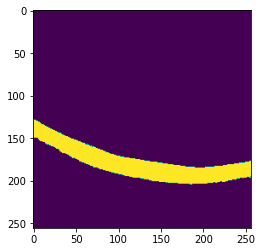

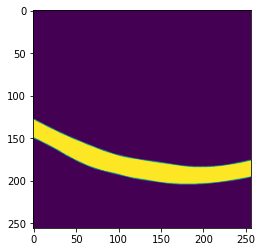

#Training [36 / 50] 0.92% loss = 0.03305 loss_acc = 0.03272 lr = 0.002058724163596069
#Training [36 / 50] 1.85% loss = 0.02623 loss_acc = 0.03373 lr = 0.002056375581410284
#Training [36 / 50] 2.77% loss = 0.04243 loss_acc = 0.03369 lr = 0.0020540279927730035
#Training [36 / 50] 3.70% loss = 0.03183 loss_acc = 0.03316 lr = 0.0020516813984766
#Training [36 / 50] 4.62% loss = 0.03425 loss_acc = 0.03409 lr = 0.0020493357993131055
#Training [36 / 50] 5.55% loss = 0.02959 loss_acc = 0.03378 lr = 0.002046991196074222
#Training [36 / 50] 6.47% loss = 0.04800 loss_acc = 0.03426 lr = 0.002044647589551314
#Training [36 / 50] 7.40% loss = 0.04223 loss_acc = 0.03473 lr = 0.002042304980535406
#Training [36 / 50] 8.32% loss = 0.02790 loss_acc = 0.03485 lr = 0.0020399633698171896
#Training [36 / 50] 9.25% loss = 0.02791 loss_acc = 0.03479 lr = 0.002037622758187018
#Training [36 / 50] 10.17% loss = 0.02726 loss_acc = 0.03417 lr = 0.0020352831464349095
#Training [36 / 50] 11.10% loss = 0.02344 loss_acc 

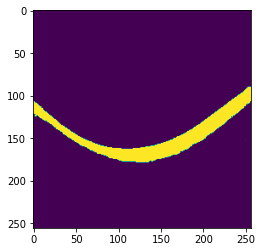

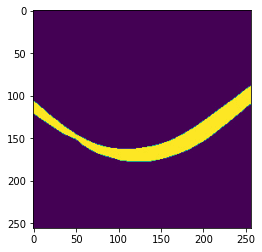

#Training [37 / 50] 0.92% loss = 0.02797 loss_acc = 0.03969 lr = 0.0018106423657240599
#Training [37 / 50] 1.85% loss = 0.02559 loss_acc = 0.03792 lr = 0.0018084057566812972
#Training [37 / 50] 2.77% loss = 0.02718 loss_acc = 0.03620 lr = 0.0018061702248831915
#Training [37 / 50] 3.70% loss = 0.02892 loss_acc = 0.03776 lr = 0.0018039357710842988
#Training [37 / 50] 4.62% loss = 0.03867 loss_acc = 0.03719 lr = 0.0018017023960387978
#Training [37 / 50] 5.55% loss = 0.02588 loss_acc = 0.03642 lr = 0.0017994701005005136
#Training [37 / 50] 6.47% loss = 0.03625 loss_acc = 0.03576 lr = 0.0017972388852229022
#Training [37 / 50] 7.40% loss = 0.04999 loss_acc = 0.03554 lr = 0.001795008750959055
#Training [37 / 50] 8.32% loss = 0.03414 loss_acc = 0.03576 lr = 0.0017927796984617004
#Training [37 / 50] 9.25% loss = 0.02802 loss_acc = 0.03554 lr = 0.0017905517284832026
#Training [37 / 50] 10.17% loss = 0.02362 loss_acc = 0.03598 lr = 0.0017883248417755535
#Training [37 / 50] 11.10% loss = 0.03819 l

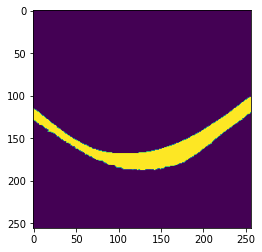

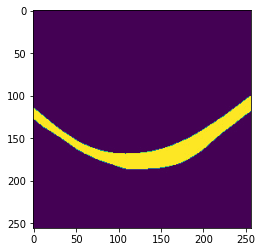

#Training [38 / 50] 0.92% loss = 0.04257 loss_acc = 0.03644 lr = 0.0015751475053556317
#Training [38 / 50] 1.85% loss = 0.03353 loss_acc = 0.03356 lr = 0.0015730316963299719
#Training [38 / 50] 2.77% loss = 0.02812 loss_acc = 0.03382 lr = 0.001570917043993734
#Training [38 / 50] 3.70% loss = 0.02860 loss_acc = 0.03383 lr = 0.0015688035490606686
#Training [38 / 50] 4.62% loss = 0.02547 loss_acc = 0.03426 lr = 0.0015666912122441353
#Training [38 / 50] 5.55% loss = 0.02922 loss_acc = 0.03428 lr = 0.0015645800342571007
#Training [38 / 50] 6.47% loss = 0.03833 loss_acc = 0.03515 lr = 0.0015624700158121418
#Training [38 / 50] 7.40% loss = 0.04295 loss_acc = 0.03470 lr = 0.0015603611576214458
#Training [38 / 50] 8.32% loss = 0.04086 loss_acc = 0.03479 lr = 0.0015582534603968004
#Training [38 / 50] 9.25% loss = 0.07304 loss_acc = 0.03526 lr = 0.0015561469248496144
#Training [38 / 50] 10.17% loss = 0.04056 loss_acc = 0.03559 lr = 0.0015540415516908928
#Training [38 / 50] 11.10% loss = 0.03733 l

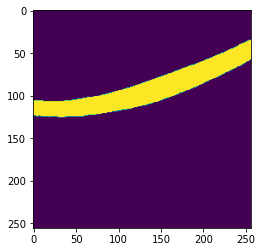

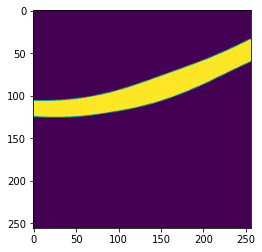

#Training [39 / 50] 0.92% loss = 0.02619 loss_acc = 0.03286 lr = 0.0013531689731172884
#Training [39 / 50] 1.85% loss = 0.02750 loss_acc = 0.03520 lr = 0.001351182314240333
#Training [39 / 50] 2.77% loss = 0.04484 loss_acc = 0.03344 lr = 0.0013491968869326397
#Training [39 / 50] 3.70% loss = 0.02369 loss_acc = 0.03354 lr = 0.0013472126918643416
#Training [39 / 50] 4.62% loss = 0.03182 loss_acc = 0.03370 lr = 0.0013452297297051536
#Training [39 / 50] 5.55% loss = 0.02500 loss_acc = 0.03336 lr = 0.001343248001124381
#Training [39 / 50] 6.47% loss = 0.02481 loss_acc = 0.03377 lr = 0.0013412675067908995
#Training [39 / 50] 7.40% loss = 0.03081 loss_acc = 0.03328 lr = 0.0013392882473731852
#Training [39 / 50] 8.32% loss = 0.05643 loss_acc = 0.03379 lr = 0.001337310223539283
#Training [39 / 50] 9.25% loss = 0.03558 loss_acc = 0.03404 lr = 0.0013353334359568283
#Training [39 / 50] 10.17% loss = 0.03268 loss_acc = 0.03382 lr = 0.0013333578852930382
#Training [39 / 50] 11.10% loss = 0.03388 los

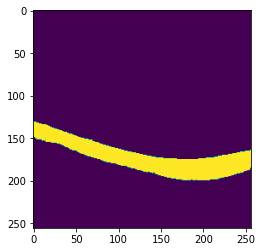

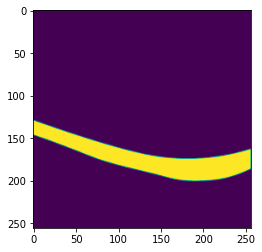

#Training [40 / 50] 0.92% loss = 0.06057 loss_acc = 0.03802 lr = 0.0011455828168634424
#Training [40 / 50] 1.85% loss = 0.05945 loss_acc = 0.03451 lr = 0.0011437331485701617
#Training [40 / 50] 2.77% loss = 0.02304 loss_acc = 0.03502 lr = 0.0011418847818655403
#Training [40 / 50] 3.70% loss = 0.02628 loss_acc = 0.03497 lr = 0.0011400377173734508
#Training [40 / 50] 4.62% loss = 0.02042 loss_acc = 0.03413 lr = 0.0011381919557173238
#Training [40 / 50] 5.55% loss = 0.03266 loss_acc = 0.03404 lr = 0.0011363474975201507
#Training [40 / 50] 6.47% loss = 0.02224 loss_acc = 0.03446 lr = 0.001134504343404483
#Training [40 / 50] 7.40% loss = 0.15094 loss_acc = 0.03536 lr = 0.0011326624939924318
#Training [40 / 50] 8.32% loss = 0.03037 loss_acc = 0.03510 lr = 0.0011308219499056719
#Training [40 / 50] 9.25% loss = 0.04324 loss_acc = 0.03517 lr = 0.0011289827117654302
#Training [40 / 50] 10.17% loss = 0.03414 loss_acc = 0.03525 lr = 0.0011271447801924983
#Training [40 / 50] 11.10% loss = 0.02860 l

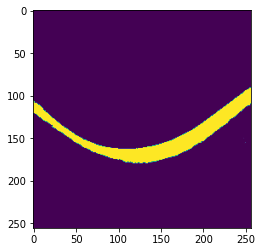

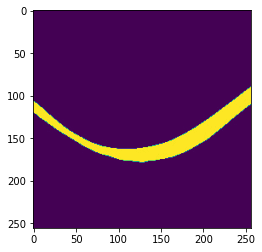

#Training [41 / 50] 0.92% loss = 0.04062 loss_acc = 0.03350 lr = 0.000953208284315721
#Training [41 / 50] 1.85% loss = 0.02011 loss_acc = 0.03314 lr = 0.0009515029064018355
#Training [41 / 50] 2.77% loss = 0.06018 loss_acc = 0.03538 lr = 0.0009497988949592332
#Training [41 / 50] 3.70% loss = 0.03282 loss_acc = 0.03496 lr = 0.0009480962505630583
#Training [41 / 50] 4.62% loss = 0.02660 loss_acc = 0.03485 lr = 0.0009463949737879987
#Training [41 / 50] 5.55% loss = 0.01961 loss_acc = 0.03442 lr = 0.0009446950652082777
#Training [41 / 50] 6.47% loss = 0.03243 loss_acc = 0.03412 lr = 0.0009429965253976612
#Training [41 / 50] 7.40% loss = 0.02611 loss_acc = 0.03360 lr = 0.0009412993549294459
#Training [41 / 50] 8.32% loss = 0.02904 loss_acc = 0.03366 lr = 0.0009396035543764718
#Training [41 / 50] 9.25% loss = 0.02102 loss_acc = 0.03392 lr = 0.0009379091243111147
#Training [41 / 50] 10.17% loss = 0.03616 loss_acc = 0.03375 lr = 0.0009362160653052884
#Training [41 / 50] 11.10% loss = 0.02833 l

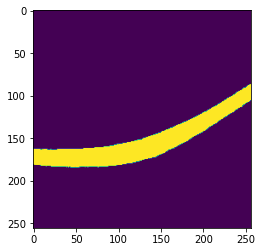

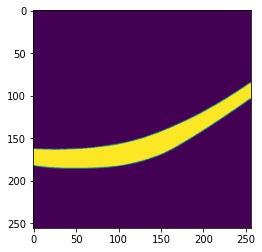

#Training [42 / 50] 0.92% loss = 0.04349 loss_acc = 0.03521 lr = 0.0007768045898665328
#Training [42 / 50] 1.85% loss = 0.03247 loss_acc = 0.03274 lr = 0.0007752502326795561
#Training [42 / 50] 2.77% loss = 0.04657 loss_acc = 0.03289 lr = 0.0007736973014536436
#Training [42 / 50] 3.70% loss = 0.02380 loss_acc = 0.03519 lr = 0.0007721457967129519
#Training [42 / 50] 4.62% loss = 0.03124 loss_acc = 0.03448 lr = 0.0007705957189811535
#Training [42 / 50] 5.55% loss = 0.03091 loss_acc = 0.03558 lr = 0.0007690470687814364
#Training [42 / 50] 6.47% loss = 0.02323 loss_acc = 0.03458 lr = 0.0007674998466365117
#Training [42 / 50] 7.40% loss = 0.03937 loss_acc = 0.03494 lr = 0.0007659540530686052
#Training [42 / 50] 8.32% loss = 0.02514 loss_acc = 0.03471 lr = 0.0007644096885994637
#Training [42 / 50] 9.25% loss = 0.02495 loss_acc = 0.03516 lr = 0.0007628667537503474
#Training [42 / 50] 10.17% loss = 0.03530 loss_acc = 0.03502 lr = 0.0007613252490420374
#Training [42 / 50] 11.10% loss = 0.02749 

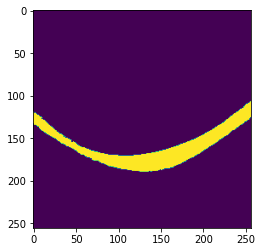

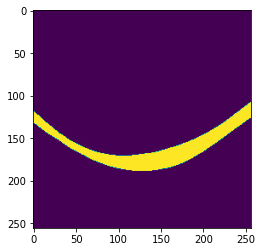

#Training [43 / 50] 0.92% loss = 0.02598 loss_acc = 0.03038 lr = 0.0006170679183066832
#Training [43 / 50] 1.85% loss = 0.05261 loss_acc = 0.03264 lr = 0.0006156707161843137
#Training [43 / 50] 2.77% loss = 0.02600 loss_acc = 0.03131 lr = 0.0006142749938851779
#Training [43 / 50] 3.70% loss = 0.02297 loss_acc = 0.03186 lr = 0.0006128807518803652
#Training [43 / 50] 4.62% loss = 0.03521 loss_acc = 0.03234 lr = 0.0006114879906404695
#Training [43 / 50] 5.55% loss = 0.03640 loss_acc = 0.03215 lr = 0.0006100967106355828
#Training [43 / 50] 6.47% loss = 0.05218 loss_acc = 0.03272 lr = 0.0006087069123352991
#Training [43 / 50] 7.40% loss = 0.02686 loss_acc = 0.03277 lr = 0.0006073185962087086
#Training [43 / 50] 8.32% loss = 0.03125 loss_acc = 0.03310 lr = 0.0006059317627244033
#Training [43 / 50] 9.25% loss = 0.02760 loss_acc = 0.03330 lr = 0.0006045464123504774
#Training [43 / 50] 10.17% loss = 0.04167 loss_acc = 0.03352 lr = 0.0006031625455545207
#Training [43 / 50] 11.10% loss = 0.04358 

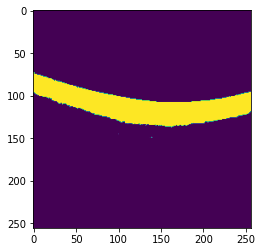

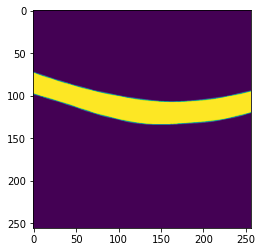

#Training [44 / 50] 0.92% loss = 0.03149 loss_acc = 0.03313 lr = 0.0004746286773020774
#Training [44 / 50] 1.85% loss = 0.02530 loss_acc = 0.03054 lr = 0.0004733941443627715
#Training [44 / 50] 2.77% loss = 0.02338 loss_acc = 0.03138 lr = 0.0004721611392686792
#Training [44 / 50] 3.70% loss = 0.04614 loss_acc = 0.03166 lr = 0.0004709296624359704
#Training [44 / 50] 4.62% loss = 0.03799 loss_acc = 0.03187 lr = 0.0004696997142803015
#Training [44 / 50] 5.55% loss = 0.02451 loss_acc = 0.03178 lr = 0.0004684712952168093
#Training [44 / 50] 6.47% loss = 0.03148 loss_acc = 0.03250 lr = 0.00046724440566011673
#Training [44 / 50] 7.40% loss = 0.03478 loss_acc = 0.03256 lr = 0.000466019046024332
#Training [44 / 50] 8.32% loss = 0.03950 loss_acc = 0.03354 lr = 0.00046479521672304516
#Training [44 / 50] 9.25% loss = 0.03720 loss_acc = 0.03357 lr = 0.00046357291816933005
#Training [44 / 50] 10.17% loss = 0.02029 loss_acc = 0.03372 lr = 0.00046235215077574234
#Training [44 / 50] 11.10% loss = 0.035

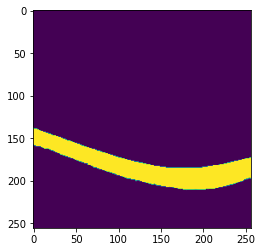

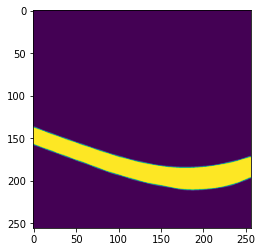

#Training [45 / 50] 0.92% loss = 0.03234 loss_acc = 0.03039 lr = 0.0003500490094626622
#Training [45 / 50] 1.85% loss = 0.04049 loss_acc = 0.03297 lr = 0.0003489820178439267
#Training [45 / 50] 2.77% loss = 0.02721 loss_acc = 0.03357 lr = 0.0003479165960626794
#Training [45 / 50] 3.70% loss = 0.04293 loss_acc = 0.03441 lr = 0.00034685274447852454
#Training [45 / 50] 4.62% loss = 0.02999 loss_acc = 0.03371 lr = 0.0003457904634505404
#Training [45 / 50] 5.55% loss = 0.02702 loss_acc = 0.03409 lr = 0.0003447297533372749
#Training [45 / 50] 6.47% loss = 0.02286 loss_acc = 0.03392 lr = 0.0003436706144967451
#Training [45 / 50] 7.40% loss = 0.02986 loss_acc = 0.03364 lr = 0.00034261304728643526
#Training [45 / 50] 8.32% loss = 0.02975 loss_acc = 0.03379 lr = 0.0003415570520633033
#Training [45 / 50] 9.25% loss = 0.02168 loss_acc = 0.03398 lr = 0.0003405026291837737
#Training [45 / 50] 10.17% loss = 0.03054 loss_acc = 0.03374 lr = 0.0003394497790037409
#Training [45 / 50] 11.10% loss = 0.0332

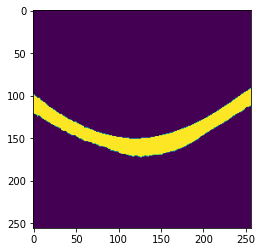

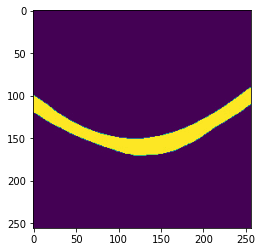

#Training [46 / 50] 0.92% loss = 0.03685 loss_acc = 0.03531 lr = 0.00024382057382236458
#Training [46 / 50] 1.85% loss = 0.02311 loss_acc = 0.03417 lr = 0.00024292533445265585
#Training [46 / 50] 2.77% loss = 0.04706 loss_acc = 0.03362 lr = 0.00024203170071727706
#Training [46 / 50] 3.70% loss = 0.03212 loss_acc = 0.03371 lr = 0.00024113967291785192
#Training [46 / 50] 4.62% loss = 0.02631 loss_acc = 0.03383 lr = 0.000240249251355463
#Training [46 / 50] 5.55% loss = 0.03053 loss_acc = 0.03356 lr = 0.0002393604363306487
#Training [46 / 50] 6.47% loss = 0.03245 loss_acc = 0.03343 lr = 0.00023847322814340858
#Training [46 / 50] 7.40% loss = 0.03994 loss_acc = 0.03417 lr = 0.00023758762709319629
#Training [46 / 50] 8.32% loss = 0.03769 loss_acc = 0.03443 lr = 0.0002367036334789256
#Training [46 / 50] 9.25% loss = 0.02647 loss_acc = 0.03460 lr = 0.00023582124759896945
#Training [46 / 50] 10.17% loss = 0.03337 loss_acc = 0.03501 lr = 0.00023494046975115076
#Training [46 / 50] 11.10% loss = 0

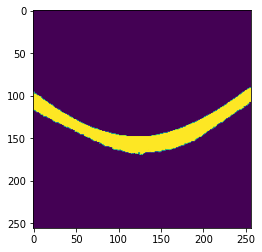

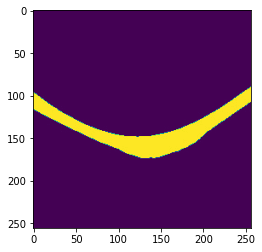

#Training [47 / 50] 0.92% loss = 0.02434 loss_acc = 0.03180 lr = 0.00015636260548549858
#Training [47 / 50] 1.85% loss = 0.03368 loss_acc = 0.03151 lr = 0.00015564265146561425
#Training [47 / 50] 2.77% loss = 0.02248 loss_acc = 0.03150 lr = 0.00015492433254019755
#Training [47 / 50] 3.70% loss = 0.04221 loss_acc = 0.03182 lr = 0.00015420764895169724
#Training [47 / 50] 4.62% loss = 0.04680 loss_acc = 0.03264 lr = 0.00015349260094201325
#Training [47 / 50] 5.55% loss = 0.02098 loss_acc = 0.03182 lr = 0.0001527791887524923
#Training [47 / 50] 6.47% loss = 0.02122 loss_acc = 0.03207 lr = 0.00015206741262392982
#Training [47 / 50] 7.40% loss = 0.02609 loss_acc = 0.03263 lr = 0.00015135727279656753
#Training [47 / 50] 8.32% loss = 0.02617 loss_acc = 0.03258 lr = 0.0001506487695100975
#Training [47 / 50] 9.25% loss = 0.02560 loss_acc = 0.03230 lr = 0.00014994190300365547
#Training [47 / 50] 10.17% loss = 0.02507 loss_acc = 0.03223 lr = 0.00014923667351582858
#Training [47 / 50] 11.10% loss =

In [ ]:
for epoch in range(epochs):
  model.train()
  n = 0
  temp = 0
  for data in (train_loader):
    optimizer.zero_grad()
    center_mask, center_raw, label, image = data
    #model = model#.double()
    #print(len(image))
    image = np.array(center_raw)
    label = np.array(center_mask)
    #print(image.shape)
    #print(label.shape)
    image = torch.tensor(image)
    #print(image.shape)
    label = torch.tensor(label)
    image = image.cuda()
    label = label.cuda()
    predict_img = model(image)#double())
    loss = dice_loss(label,predict_img)#.double())
    loss.backward()
    optimizer.step()
    #optimizer.zero_grad()
    loss = loss.item()
    b = image.shape[0]
    n = n+b
    delta = b*(loss - loss_accum)
    loss_accum += delta/n
    scheduler.step()
    temp = temp + 1
    if temp == 20:
      print('#Training [{} / {}] {:.2%} loss = {:.5f} loss_acc = {:.5f} lr = {}'.format(epoch+1, epochs, n/len(train_idx), loss, loss_accum, float(optimizer.param_groups[0]['lr'])))
      temp = 0
  MODEL_SAVE_PATH = f"/content/gdrive/MyDrive/11785/project/DUNet2_epoch_{epoch+1}.pt"
  torch.save({'batch_size': batch_size,'init_lr':lr,'lr': float(optimizer.param_groups[0]['lr']),'epoch': epochs ,'model_state_dict': model.state_dict(),
            'scheduler':"optim.lr_scheduler.CosineAnnealing",'loss_acc': loss_accum}, MODEL_SAVE_PATH)
    # plt.figure()
    # plt.imshow(predict_img[0].cpu().detach().numpy().reshape(256,256))
    # plt.show()
    # fig = plt.figure()
    # plt.imshow(label[0].cpu().detach().numpy().reshape(256,256))
  #scheduler.step()
  torch.cuda.empty_cache()
  model.eval()
  n = 0
  for data in (valid_loader):
    center_mask, center_raw, label, image = data
    #model = model#.double()
    #print(len(image))
    image = np.array(center_raw)
    label = np.array(center_mask)
    #print(image.shape)
    #print(label.shape)
    image = torch.tensor(image)
    #print(image.shape)
    label = torch.tensor(label)
    image = image.cuda()
    label = label.cuda()
    with torch.no_grad():
      predict_img = model(image)#double())
    loss = dice_loss(label,predict_img)#.double())
    loss = loss.item()
    b = image.shape[0]
    n = n+b
    delta = b*(loss - loss_accum)
    loss_accum += delta/n
    temp = temp + 1
    if temp == 20:
      print('#Validation [{} / {}] {:.2%} loss = {:.5f} loss_acc = {:.5f}'.format(epoch+1, epochs, n/len(valid_idx), loss, loss_accum))
      temp = 0

  plt.figure()
  plt.imshow(predict_img[0].cpu().detach().numpy().reshape(256,256))
  plt.show()
  fig = plt.figure()
  plt.imshow(label[0].cpu().detach().numpy().reshape(256,256))
  plt.show()
  # plt.imshow(image.cpu().detach().numpy().reshape(256,256))

In [ ]:
MODEL_SAVE_PATH = f"/content/gdrive/MyDrive/11785/project/DUNet2_epoch_46.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
saved = torch.load(MODEL_SAVE_PATH)
model_load = DUNetV1V2(n_channels=1)
model_load.load_state_dict(saved["model_state_dict"])
model_load.to(device)
# print(model_load)
model=model_load

/usr/local/lib/python3.7/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Testing 0.92% loss = 0.04374 loss_acc = 0.04072 dice_coeff 0.95626
Testing 1.85% loss = 0.04971 loss_acc = 0.04472 dice_coeff 0.95029
Testing 2.77% loss = 0.02683 loss_acc = 0.04391 dice_coeff 0.97317
Testing 3.70% loss = 0.02558 loss_acc = 0.04357 dice_coeff 0.97442
Testing 4.62% loss = 0.10974 loss_acc = 0.04921 dice_coeff 0.89026
Testing 5.55% loss = 0.04399 loss_acc = 0.04716 dice_coeff 0.95601
Testing 6.47% loss = 0.03063 loss_acc = 0.04687 dice_coeff 0.96937
Testing 7.40% loss = 0.04494 loss_acc = 0.04678 dice_coeff 0.95506
Testing 8.32% loss = 0.04239 loss_acc = 0.04599 dice_coeff 0.95761
Testing 9.25% loss = 0.03782 loss_acc = 0.04645 dice_coeff 0.96218
Testing 10.17% loss = 0.05947 loss_acc = 0.04710 dice_coeff 0.94053
Testing 11.10% loss = 0.06553 loss_acc = 0.04766 dice_coeff 0.93447
Testing 12.02% loss = 0.06390 loss_acc = 0.04801 dice_coeff 0.93610
Testing 12.94% loss = 0.04059 loss_acc = 0.05094 dice_coeff 0.95941
Testing 13.87% loss = 0.07076 loss_acc = 0.05109 dice_coef

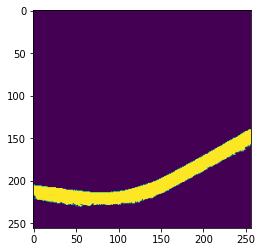

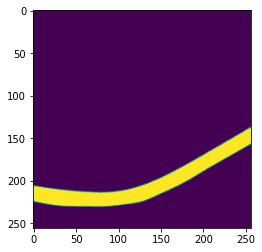

tensor(0.9524, device='cuda:0')


In [ ]:
# testing
torch.cuda.empty_cache()
model.eval()
n = 0
temp = 0
dice = 0
for data in (test_loader):
  center_mask, center_raw, label, image = data
  #model = model#.double()
  #print(len(image))
  image = np.array(center_raw)
  label = np.array(center_mask)
  #print(image.shape)
  #print(label.shape)
  image = torch.tensor(image)
  #print(image.shape)
  label = torch.tensor(label)
  image = image.cuda()
  label = label.cuda()
  with torch.no_grad():
    predict_img = model(image)#double())
  loss = dice_loss(label,predict_img)#.double())
  loss = loss.item()
  b = image.shape[0]
  n = n+b
  delta = b*(loss - loss_accum)
  loss_accum += delta/n
  dice += dice_coeff(label, predict_img)
  temp = temp + 1
  if temp == 5:
    print('Testing {:.2%} loss = {:.5f} loss_acc = {:.5f} dice_coeff {:.5f}'.format(n/len(test_idx), loss, loss_accum, dice_coeff(label, predict_img)))
    temp = 0

plt.figure()
plt.imshow(predict_img[0].cpu().detach().numpy().reshape(256,256))
plt.show()
fig = plt.figure()
plt.imshow(label[0].cpu().detach().numpy().reshape(256,256))
plt.show()
print(4*dice/len(test_idx))

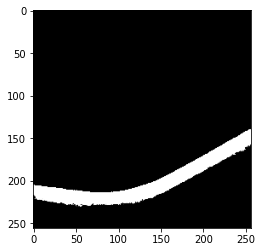

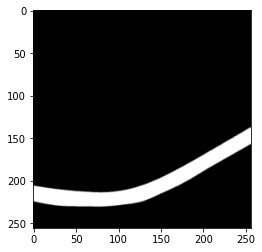

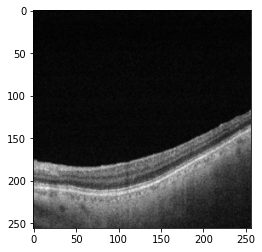

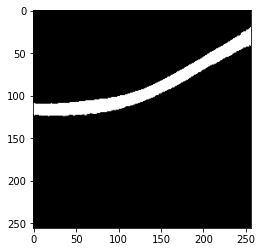

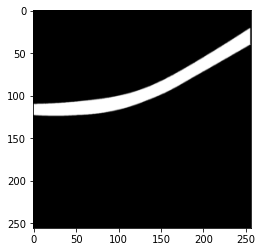

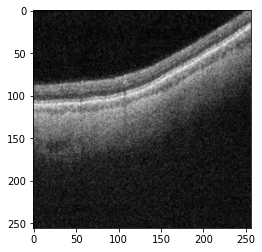

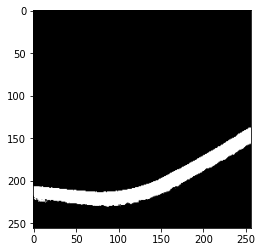

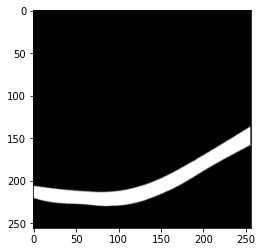

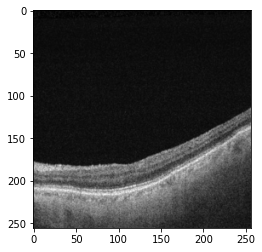

In [ ]:
for i in range(3):
  plt.figure()
  plt.imshow(predict_img[i].cpu().detach().numpy().reshape(256,256),cmap = 'gray')
  plt.show()
  fig = plt.figure()
  plt.imshow(label[i].cpu().detach().numpy().reshape(256,256),cmap = 'gray')
  plt.show()
  fig = plt.figure()
  plt.imshow(image[i].cpu().detach().numpy().reshape(256,256),cmap = 'gray')
  plt.show()

In [ ]:
# save ouput
from torchvision.utils import save_image
torch.save(optimizer.state_dict(), "/content/gdrive/MyDrive/11-785-s22/Temp Project/optimizer")
torch.save(scheduler.state_dict(), "/content/gdrive/MyDrive/11-785-s22/Temp Project/scheduler")
torch.save(model.state_dict(), "/content/gdrive/MyDrive/11-785-s22/Temp Project/model")
temp = 1
for data in (train_loader):
    center_mask, center_raw, label, image = data
    #model = model#.double()
    #print(len(image))
    image = np.array(center_raw)
    label = np.array(center_mask)
    #print(image.shape)
    #print(label.shape)
    image = torch.tensor(image)
    #print(image.shape)
    label = torch.tensor(label)
    image = image.cuda()
    label = label.cuda()
    predict_img = model(image)#double())
    plt.figure()
    plt.imshow(image[0].cpu().detach().numpy().reshape(256,256), cmap = 'gray')
    plt.figure()
    plt.imshow(label[0].cpu().detach().numpy().reshape(256,256), cmap = 'gray')
    plt.figure()
    plt.imshow(predict_img[0].cpu().detach().numpy().reshape(256,256), cmap = 'gray')

    save_image(image[0], "/content/gdrive/MyDrive/11-785-s22/Temp Project/img" + str(temp) + '.png')

    save_image(label[0], "/content/gdrive/MyDrive/11-785-s22/Temp Project/truth" + str(temp) + '.png')

    save_image(predict_img[0], "/content/gdrive/MyDrive/11-785-s22/Temp Project/pred" + str(temp) + '.png')
    temp = temp + 1
    if temp == 4:
      break

# print ("test")
# temp = 1
# for data in (val_loader):
#     center_mask, center_raw, label, image = data
#     #model = model#.double()
#     #print(len(image))
#     image = np.array(center_raw)
#     label = np.array(center_mask)
#     #print(image.shape)
#     #print(label.shape)
#     image = torch.tensor(image)
#     #print(image.shape)
#     label = torch.tensor(label)
#     image = image.cuda()
#     label = label.cuda()
#     predict_img = model(image)#double())
#     plt.figure()
#     plt.imshow(image[0].cpu().detach().numpy().reshape(256,256), cmap = 'gray')
#     plt.figure()
#     plt.imshow(label[0].cpu().detach().numpy().reshape(256,256), cmap = 'gray')
#     plt.figure()
#     plt.imshow(predict_img[0].cpu().detach().numpy().reshape(256,256), cmap = 'gray')
#     temp = temp + 1
#     if temp == 4:
#       break
# plt.savefig('foo.png')



In [ ]:
del model
torch.cuda.empty_cache()
!nvidia-smi